## Key Drivers of Housing Prices
Data Source & Data Discription: https://www.kaggle.com/competitions/home-data-for-ml-course/data?select=data_description.txt<br>
Team: Mannan Mishra, Suvass Ravala, Fuling Wang

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_train = pd.read_csv('train.csv')
pd.set_option('display.max_columns', None)
data_train['price_per_sqft'] = data_train['SalePrice']/data_train['GrLivArea']
data_train['price_rank'] = pd.qcut(data_train['price_per_sqft'], 4, labels=False)
data_train = data_train.drop(columns = ['Id'])
data_train.shape

(1460, 82)

In [3]:
# There are 43 qualitatitive attributes and 46 quantitative attributes, 89 in total
quantitative = ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']
qualitatitve = ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']

## Data Cleaning

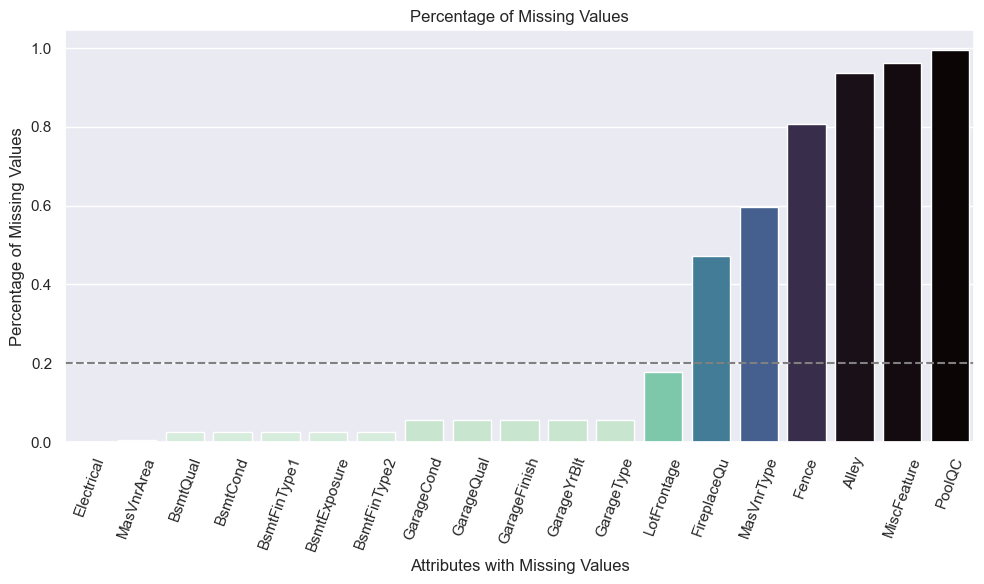

In [4]:
missing_data = data_train.isna().sum()
missing_data = missing_data[missing_data>0].sort_values()
missing_data = pd.DataFrame(missing_data)/data_train.shape[0]
missing_data.columns = ['num_nan']

sns.set_theme(rc={'figure.figsize':(10,6)})
palette = sns.color_palette("mako_r", as_cmap=True)
norm = plt.Normalize(missing_data['num_nan'].min(), missing_data['num_nan'].max())
colors = palette(norm(missing_data['num_nan']))

sns.barplot(x=missing_data.index,
    y=missing_data['num_nan'],
    palette=colors)

plt.axhline(y=0.2, color='grey', linestyle='--')
plt.title('Percentage of Missing Values')
plt.xticks(rotation = 70)
plt.ylabel('Percentage of Missing Values')
plt.xlabel('Attributes with Missing Values')
plt.tight_layout()

**Comments on missing data** <br>
- There are 7 attributes have over 10% missing values, among those 7, only Lot Frontage is quantitative.
- Aside from Lot Frontage, the other 6 have more than 40% samples missing, we will drop these qualitative attributes to ensure data quality.

In [5]:
# Dropping columns with 30%+ nans
col_to_drop = list(missing_data[missing_data['num_nan']> 0.3].index)
qualitatitive_new = list(set(qualitatitve) - set(col_to_drop))
quantitative_new = list(set(quantitative) - set(col_to_drop))

## Feature Selection

#### How to filter attributes 
- Are the categories evenly distributed? `freq` should be less than half?
- Are the groups significantly differ from each other? (ANOVA) <br>
- Are the attributes relevant to dependent variable

In [6]:
# Typecast all the qualitative data to be 'category'
data_train[qualitatitive_new] = data_train[qualitatitive_new].astype('category')
qual_des_df = data_train[qualitatitive_new].describe()
qual_des_df

,MSZoning,BsmtFinType2,GarageFinish,BsmtExposure,BsmtCond,Exterior2nd,BldgType,CentralAir,HeatingQC,LandSlope,PavedDrive,Street,SaleCondition,ExterCond,Foundation,LandContour,Electrical,BsmtQual,LotConfig,RoofStyle,ExterQual,BsmtFinType1,Exterior1st,GarageQual,Condition2,RoofMatl,Utilities,Condition1,Heating,GarageCond,LotShape,SaleType,HouseStyle,Neighborhood,Functional,KitchenQual,GarageType
count,1460,1422,1379,1422,1423,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1459,1423,1460,1460,1460,1423,1460,1379,1460,1460,1460,1460,1460,1379,1460,1460,1460,1460,1460,1460,1379
unique,5,6,3,4,4,16,5,2,5,3,3,2,6,5,6,4,5,4,5,6,4,6,15,5,8,8,2,9,6,5,4,9,8,25,7,4,6
top,RL,Unf,Unf,No,TA,VinylSd,1Fam,Y,Ex,Gtl,Y,Pave,Normal,TA,PConc,Lvl,SBrkr,TA,Inside,Gable,TA,Unf,VinylSd,TA,Norm,CompShg,AllPub,Norm,GasA,TA,Reg,WD,1Story,NAmes,Typ,TA,Attchd
freq,1151,1256,605,953,1311,504,1220,1365,741,1382,1340,1454,1198,1282,647,1311,1334,649,1052,1141,906,430,515,1311,1445,1434,1459,1260,1428,1326,925,1267,726,225,1360,735,870


Text(0.5, 1.0, 'Top Category Frequency')

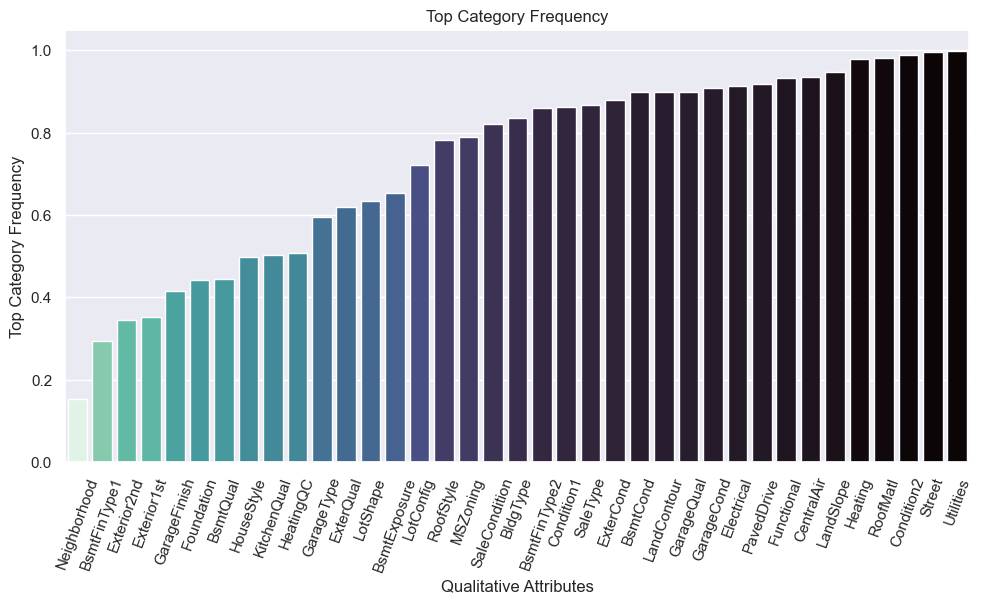

In [7]:
# Check Frequency of the top category
qual_top_freq = (pd.DataFrame(qual_des_df.T['freq'])/data_train.shape[0]).sort_values(by='freq')
qual_top_freq['freq'] = pd.to_numeric(qual_top_freq['freq'], errors='coerce')
sns.set_theme(rc={'figure.figsize':(10,6)})
palette = sns.color_palette("mako_r", as_cmap=True)
norm = plt.Normalize(qual_top_freq['freq'].min(), qual_top_freq['freq'].max())
colors = palette(norm(qual_top_freq['freq']))

sns.barplot(x=qual_top_freq.index,
    y=qual_top_freq['freq'],
    palette=colors)
plt.xticks(rotation = 70)
plt.ylabel('Top Category Frequency')
plt.xlabel('Qualitative Attributes')
plt.tight_layout()
plt.title('Top Category Frequency')

<Axes: xlabel='BsmtQual', ylabel='price_per_sqft'>

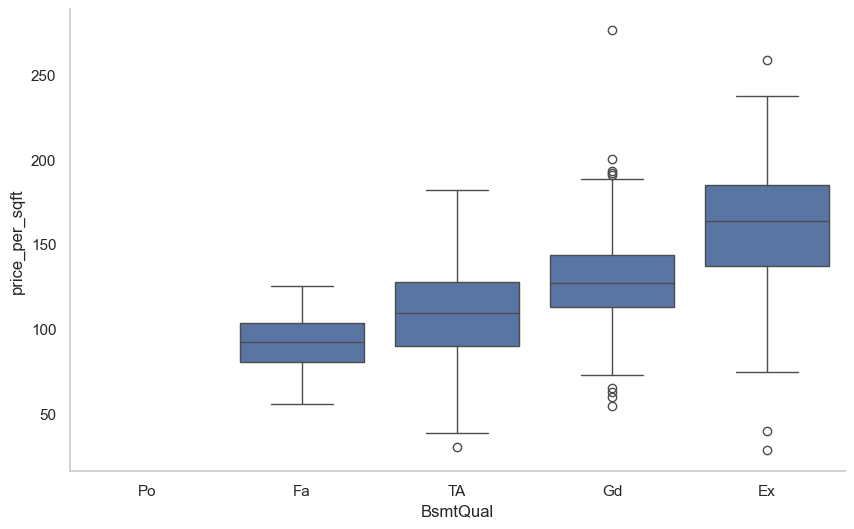

In [8]:
sns.color_palette("mako", as_cmap=True)
sns.set_theme(style='whitegrid',rc=custom_params)

sns.boxplot(data=data_train, x='BsmtQual', y='price_per_sqft', order=['Po', 'Fa', 'TA', 'Gd', 'Ex'])

In [9]:
data_train.groupby('BsmtQual').agg({'price_per_sqft':np.mean}).sort_values(by='price_per_sqft', ascending = False)

,price_per_sqft
BsmtQual,
Ex,162.372357
Gd,128.626064
TA,108.659371
Fa,91.497656


In [10]:
# Conduct the one-way ANOVA to see if the groups are significantly different from each other
anova = {}
for col in qualitatitive_new:
    group = {}
    categories = list(set(data_train[col]))
    for num in range(len(categories)):
        group[categories[num]] = data_train[data_train[col] == categories[num]]['price_per_sqft']
    group_vals = list(group.values())
    anova[col] = f_oneway(*group_vals)

# List all the qualitative attributes with a p_value less than 0.05
qual_anova_stats = [(col, anova[col][1]) for col in qualitatitive_new if anova[col][1] < 0.05]
qual_anova_feature = [item[0] for item in qual_anova_stats]
qual_anova_val = [item[1] for item in qual_anova_stats]

Text(0.5, 1.0, 'Qualitative Attributes With Categories Significantly Differ')

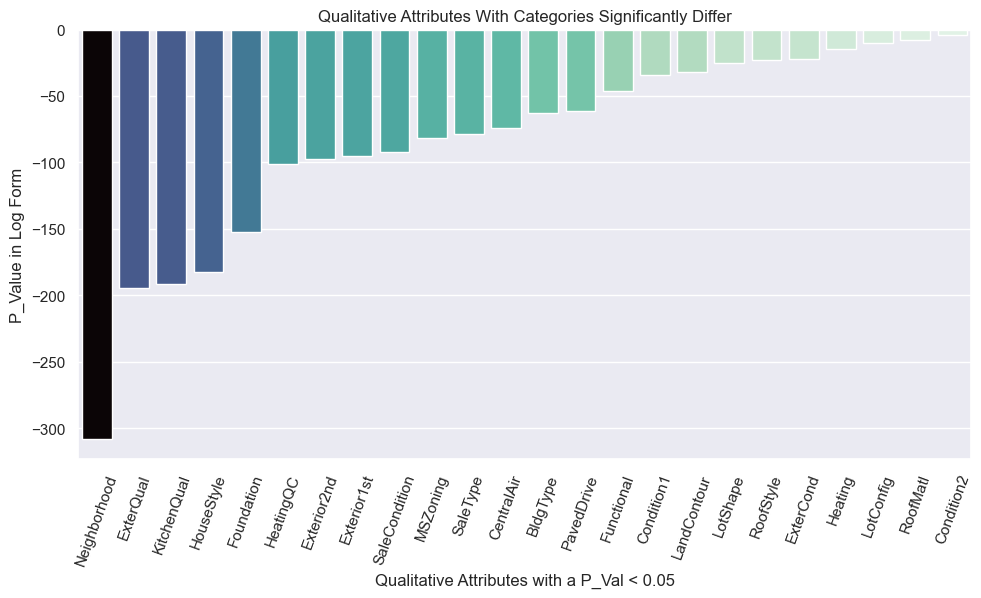

In [12]:
anova = pd.DataFrame({'qual': qual_anova_feature, 'ANOVA_pval_log': np.log(qual_anova_val)}).sort_values(by = 'ANOVA_pval_log')
sns.set_theme(rc={'figure.figsize':(10,6)})
palette = sns.color_palette("mako", as_cmap=True)
norm = plt.Normalize(anova['ANOVA_pval_log'].min(), anova['ANOVA_pval_log'].max())
colors = palette(norm(anova['ANOVA_pval_log']))
sns.barplot(data = anova, x= 'qual', y ='ANOVA_pval_log', palette=colors)
plt.xticks(rotation = 70)
plt.ylabel('P_Value in Log Form')
plt.xlabel('Qualitative Attributes with a P_Val < 0.05')
plt.tight_layout()
plt.title('Qualitative Attributes With Categories Significantly Differ')

In [13]:
# Filter ordinal categories
qual_des_df_T = qual_des_df.T
qualitatitve_Ordinal = list(qual_des_df_T[(qual_des_df_T['unique']<=5) & (qual_des_df_T['top'].isin(['Ex', 'TA', 'Typ', 'Gd', 'Po', 'Fa']))].index)
qualitatitve_non_Ord = list(set(qualitatitive_new) - set(qualitatitve_Ordinal))
qualitatitve_Ordinal

['BsmtCond',
 'HeatingQC',
 'ExterCond',
 'BsmtQual',
 'ExterQual',
 'GarageQual',
 'GarageCond',
 'KitchenQual']

In [14]:
# Calculate correlation between ordinal attributes and saleprices
quality_mapping = {'Po': 1, 'Fa': 2, 'TA': 3, 'Typ': 3, 'Gd': 4, 'Ex': 5}
corr_table = pd.DataFrame(index = qualitatitve_Ordinal)
for col in qualitatitve_Ordinal:
    col_encoded = data_train[col].map(quality_mapping)
    corr_table.loc[col,0] = data_train['price_per_sqft'].corr(col_encoded)
corr_table.columns = ['Correlation_w_SalesPrice']
corr_table = corr_table.sort_values(by='Correlation_w_SalesPrice',ascending = False)

Text(0.5, 1.0, 'Correlation with Price per sqft')

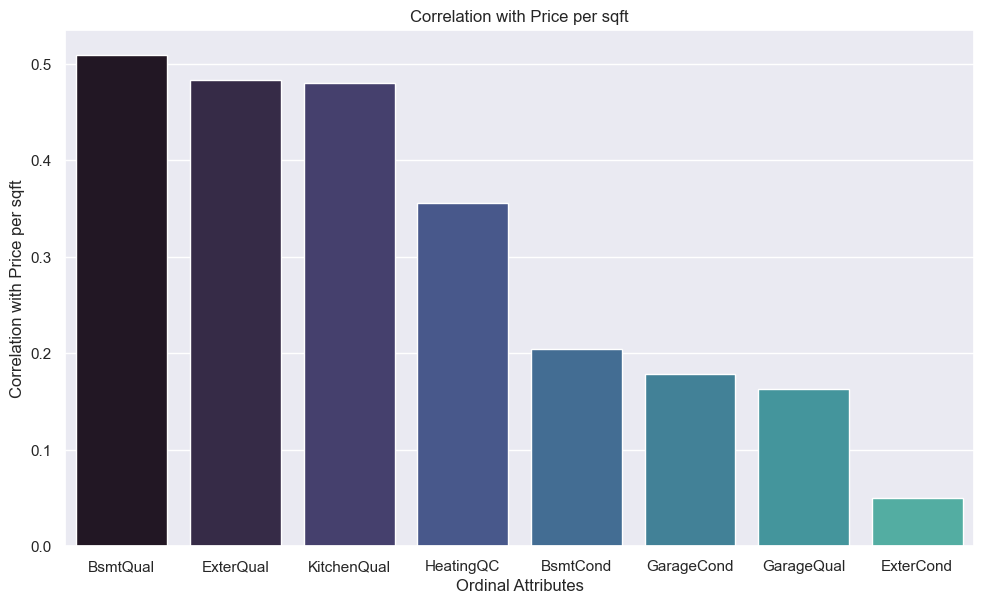

In [16]:
palette = sns.color_palette("mako", 10)
sns.set_palette(palette)
sns.barplot(corr_table, x = corr_table.index, y = 'Correlation_w_SalesPrice', palette=palette)
plt.ylabel('Correlation with Price per sqft')
plt.xlabel('Ordinal Attributes')
plt.tight_layout()
plt.title('Correlation with Price per sqft')

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

le_target = LabelEncoder()
data_train['price_rank'] = le_target.fit_transform(data_train['price_rank'])  # Encode target

# Use one-hot encoding for categorical features
df_encoded = pd.get_dummies(data_train[qualitatitve_non_Ord])

# Step 2: Train a decision tree classifier
X = df_encoded
y = data_train['price_rank']
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X, y)

# Step 3: Extract feature importances
feature_cat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_cat_importance)

feature_cat_importance['feature'] = [feature_cat_importance['Feature'][i].split('_')[0] for i in range(feature_cat_importance.shape[0])]
feature_importance = pd.DataFrame(feature_cat_importance.groupby('feature')['Importance'].sum().sort_values(ascending = False))
feature_importance['Cumulative'] = feature_importance['Importance'].cumsum()
informative_features = feature_importance[feature_importance['Cumulative'] <= 0.95]

                 Feature  Importance
150    HouseStyle_1Story    0.066362
83      BsmtFinType1_GLQ    0.059322
57      Foundation_PConc    0.030024
17       BsmtExposure_No    0.023286
12      GarageFinish_RFn    0.022209
..                   ...         ...
91    Exterior1st_CBlock    0.000000
94   Exterior1st_ImStucc    0.000000
134         Heating_Wall    0.000000
133         Heating_OthW    0.000000
97     Exterior1st_Stone    0.000000

[194 rows x 2 columns]


Text(0.5, 0, 'Non-Ordinal Features')

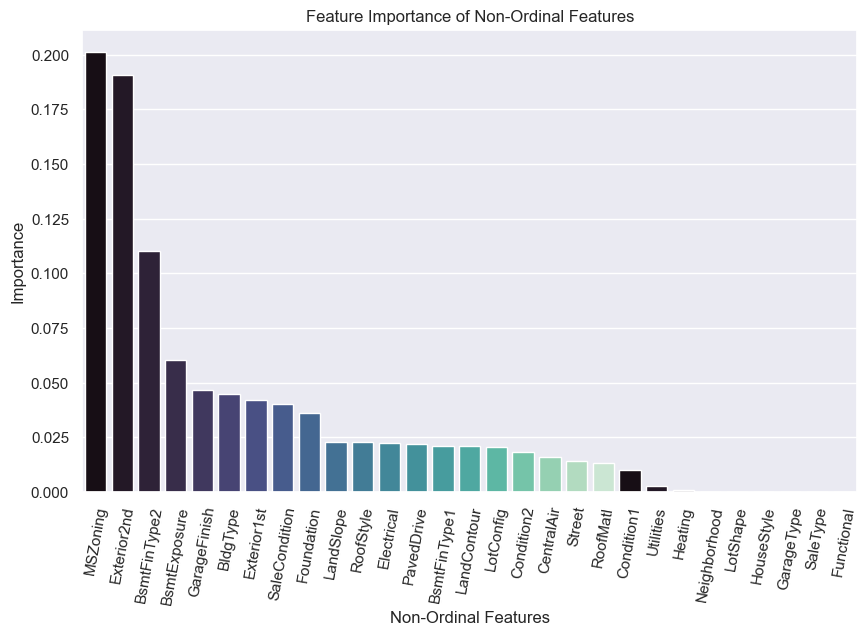

In [18]:
palette = sns.color_palette("mako", 20)
sns.barplot(feature_importance['Importance'], palette=palette)
plt.xticks(rotation=80)
plt.title('Feature Importance of Non-Ordinal Features')
plt.xlabel('Non-Ordinal Features')

In [19]:
ord_feature_list = list(corr_table.iloc[:8].index)
ord_feature_list

['BsmtQual',
 'ExterQual',
 'KitchenQual',
 'HeatingQC',
 'BsmtCond',
 'GarageCond',
 'GarageQual',
 'ExterCond']

In [20]:
non_ord_feature_list = list(feature_importance[feature_importance['Cumulative']<=0.9].index)
non_ord_feature_list

['MSZoning',
 'Exterior2nd',
 'BsmtFinType2',
 'BsmtExposure',
 'GarageFinish',
 'BldgType',
 'Exterior1st',
 'SaleCondition',
 'Foundation',
 'LandSlope',
 'RoofStyle',
 'Electrical',
 'PavedDrive',
 'BsmtFinType1']

I narrowed the qualitative list down to 8 ordinal + 10 non-ordinal;<br>
or 3 + 8 if we exclude below two lists that didnt pass my ANOVA test<br>
`{'BsmtCond', 'BsmtQual', 'FireplaceQu', 'GarageCond', 'GarageQual'}`<br>
`{'Electrical', 'GarageType'}`

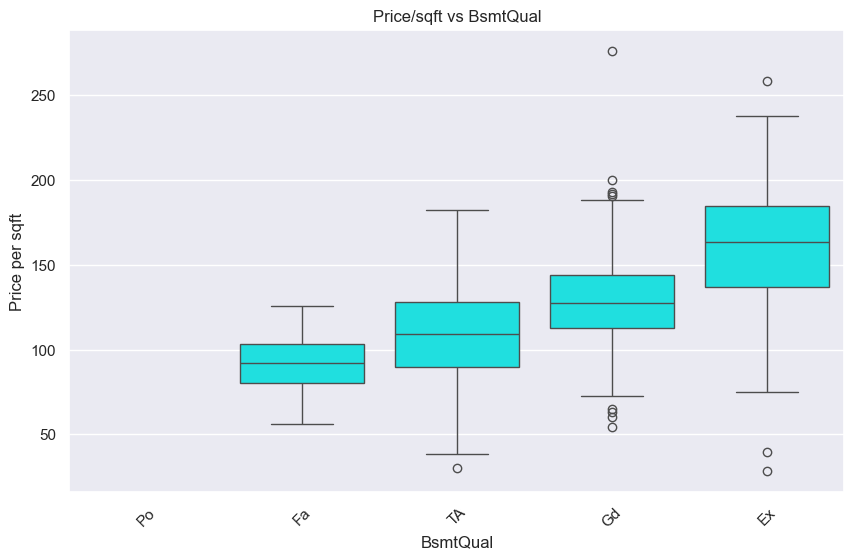

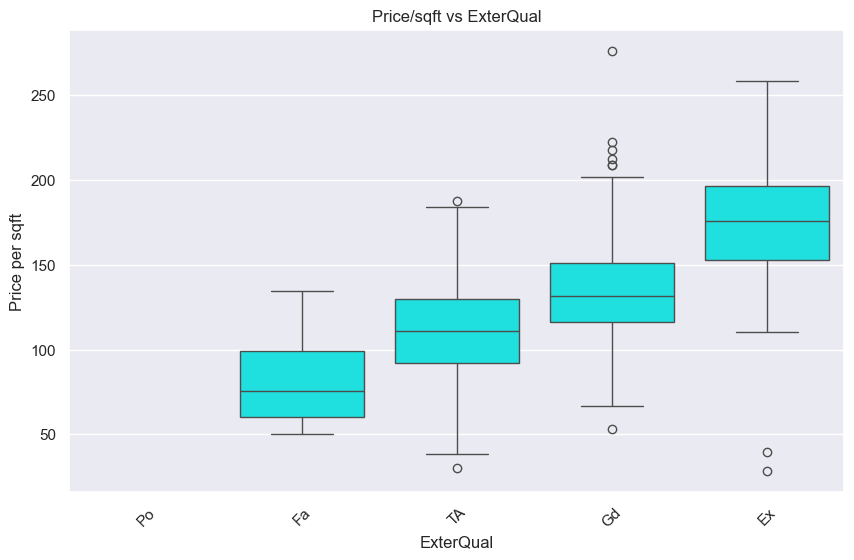

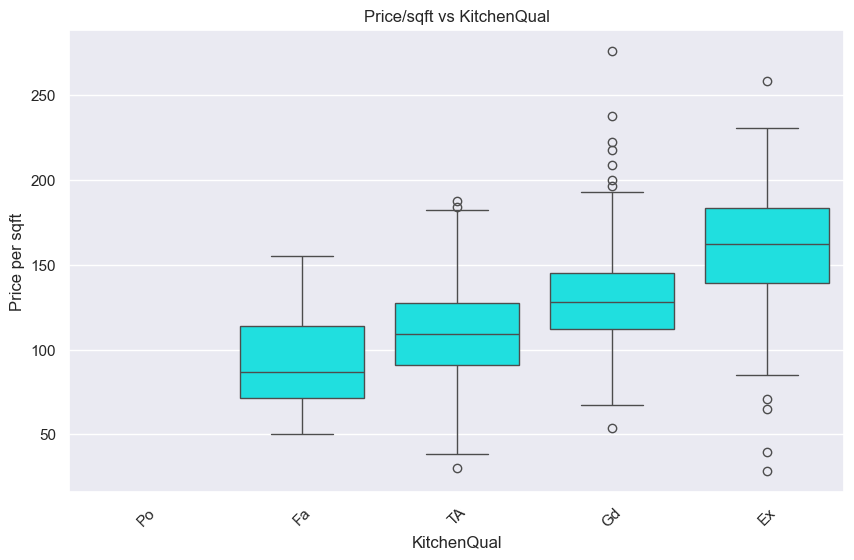

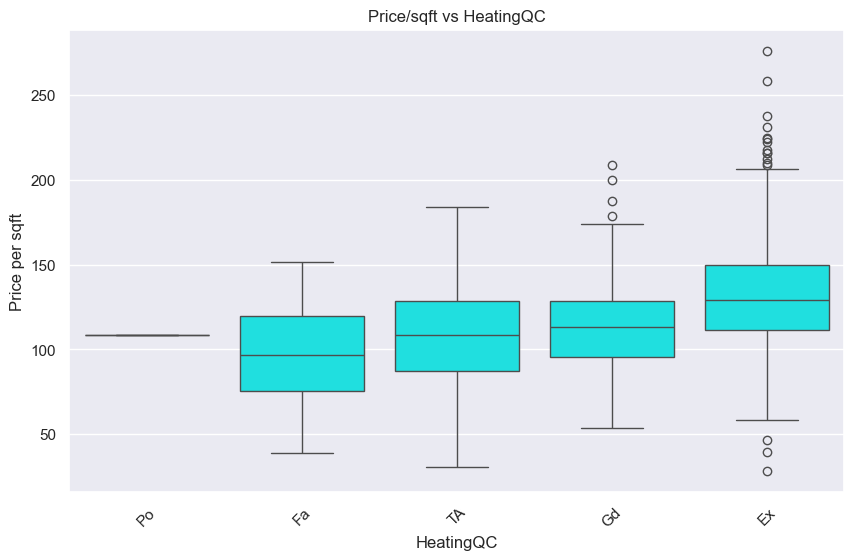

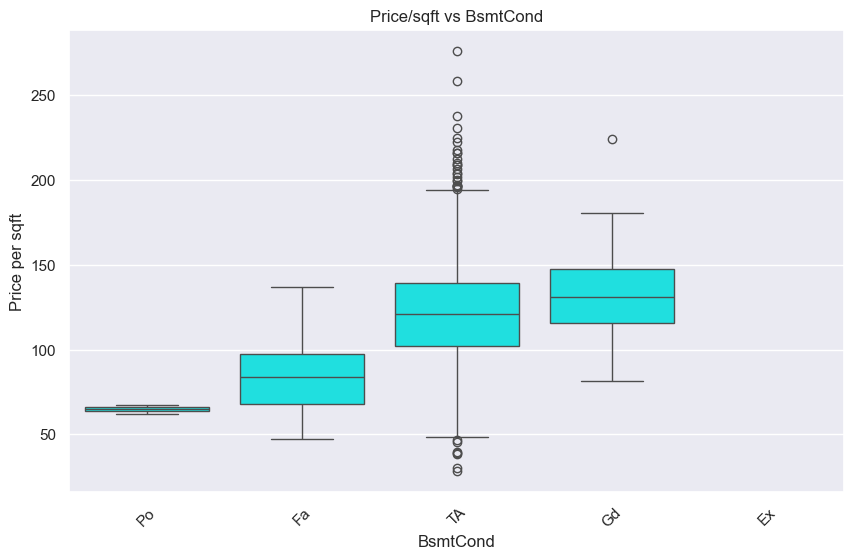

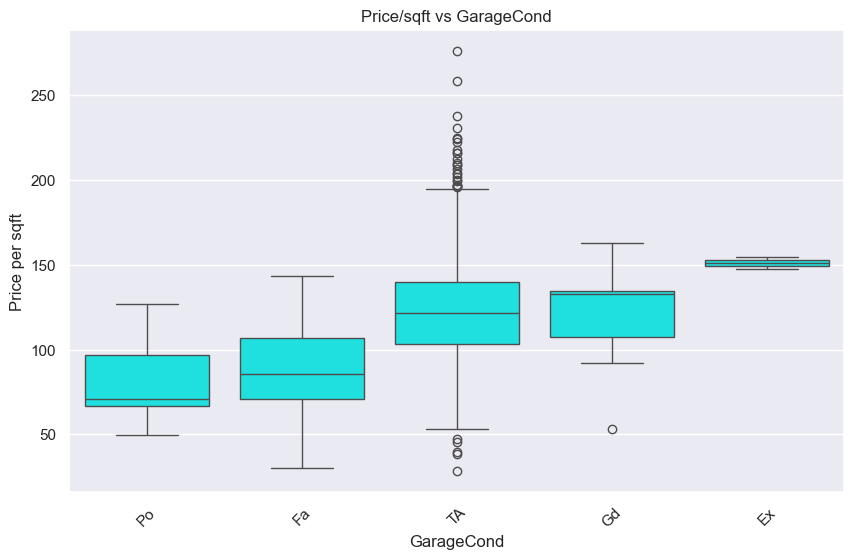

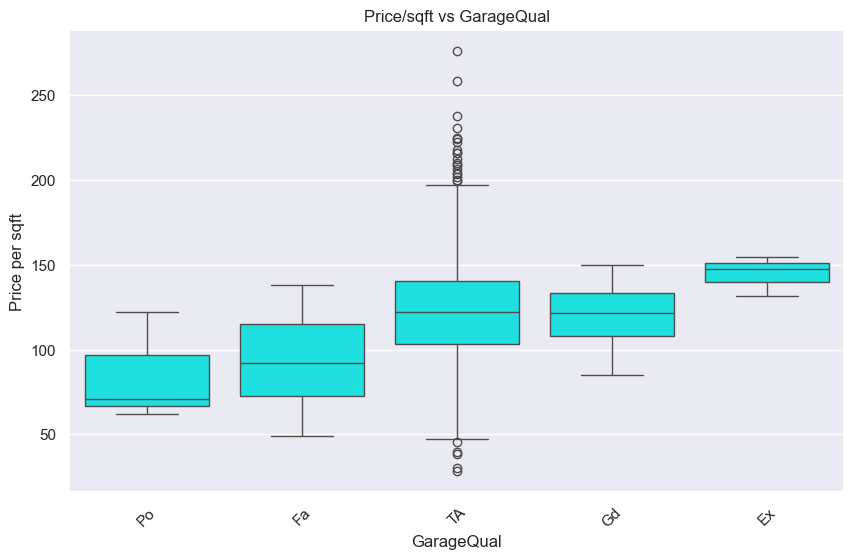

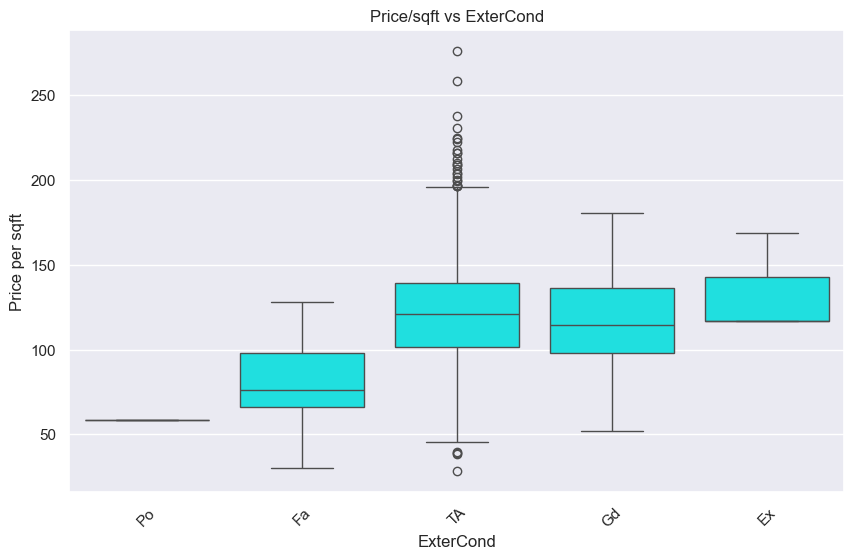

In [28]:
# plot the ordinal factors
for col in ord_feature_list:    
    my_plot = sns.boxplot(data =data_train, x=col, y='price_per_sqft', color = 'cyan', order=['Po', 'Fa', 'TA', 'Gd', 'Ex'])
    plt.xticks(rotation=45)
    plt.title("Price/sqft vs " + col)
    plt.ylabel("Price per sqft")
    plt.show()

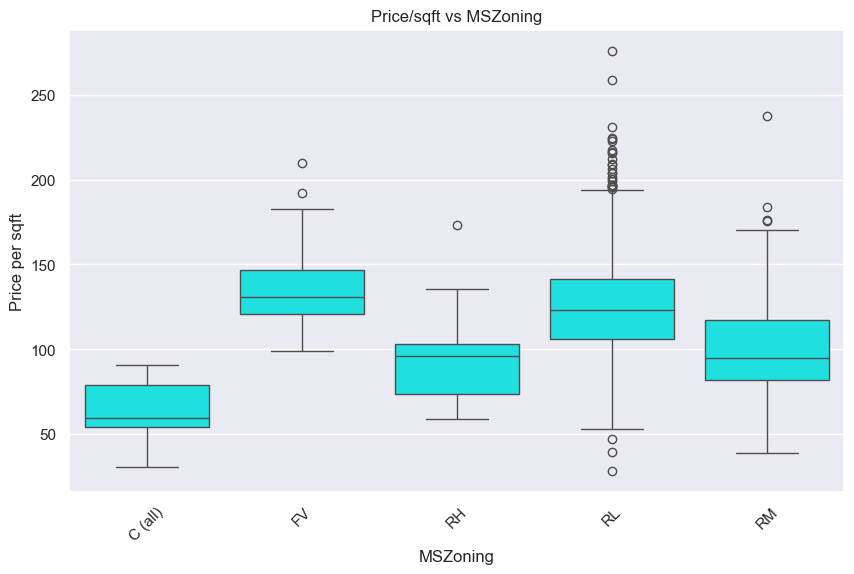

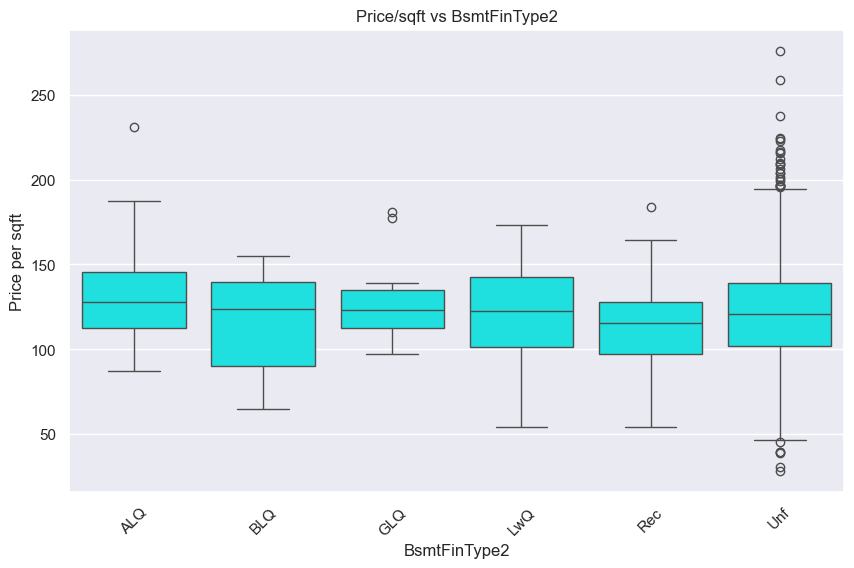

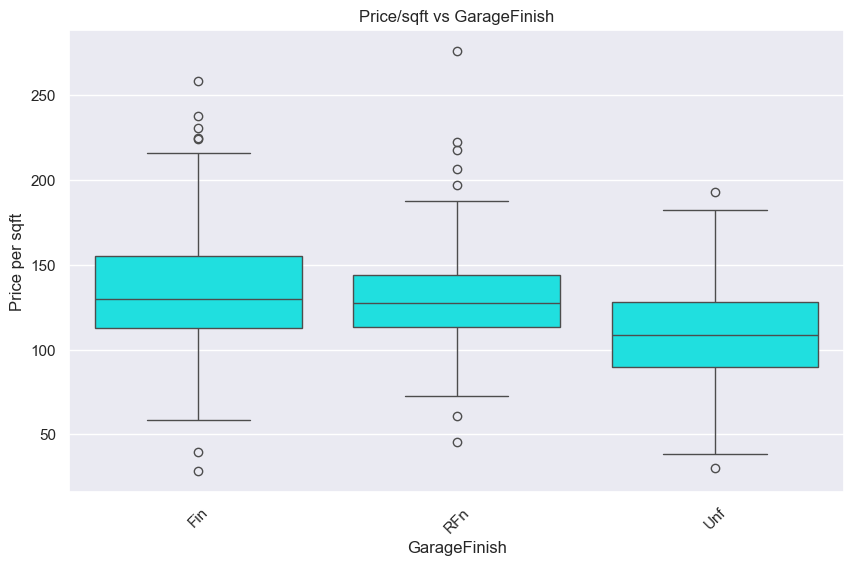

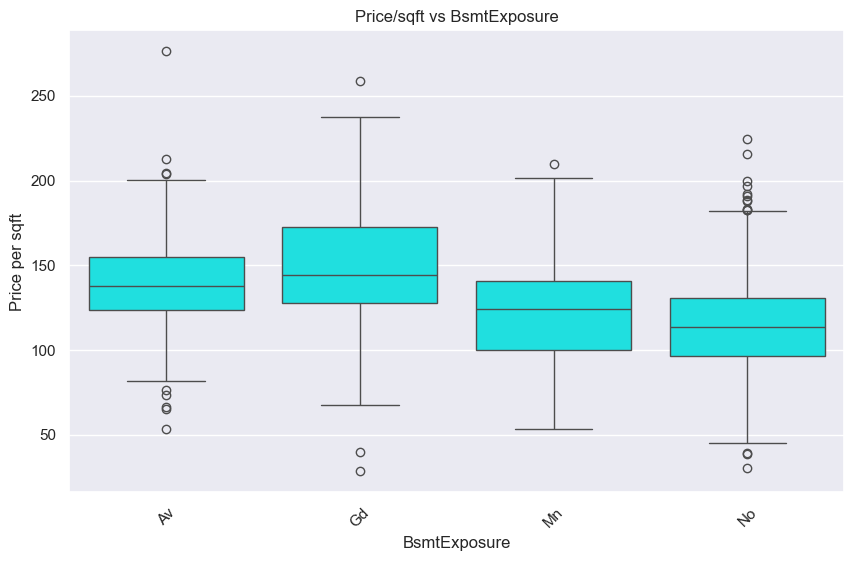

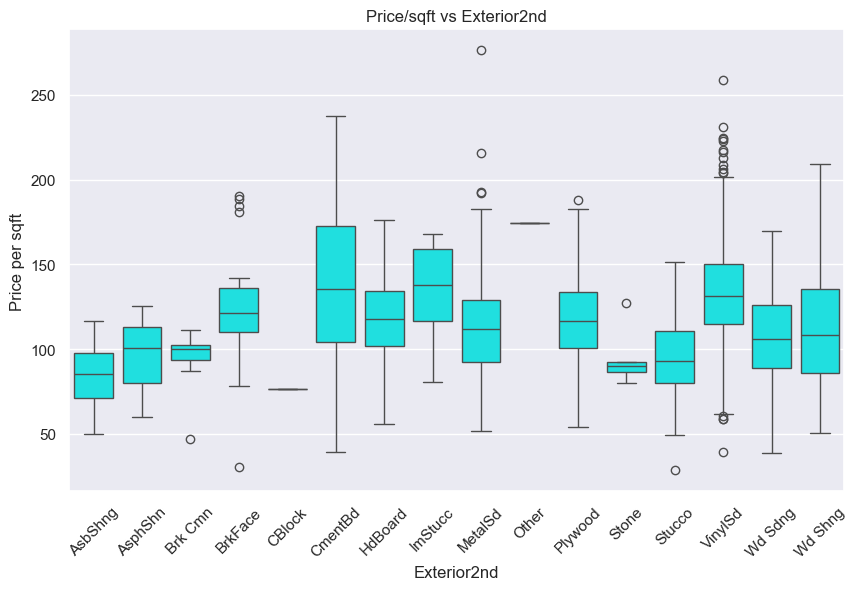

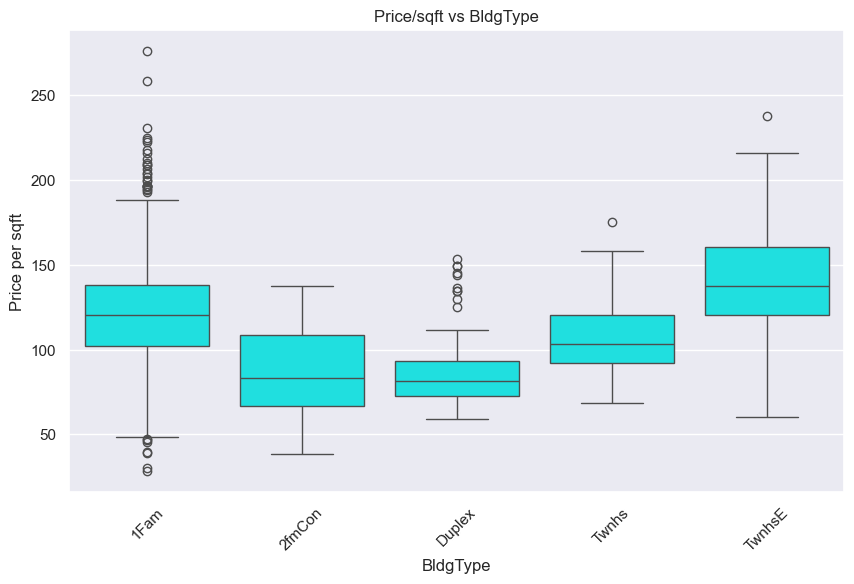

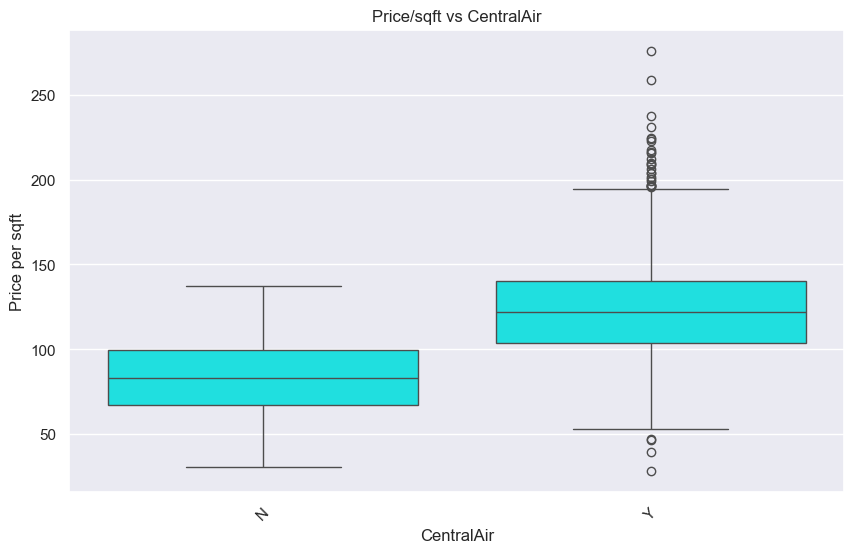

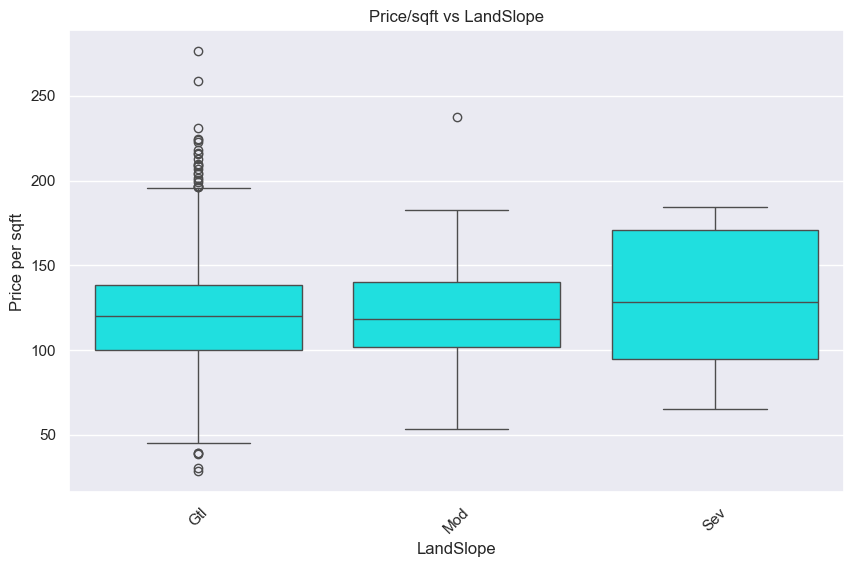

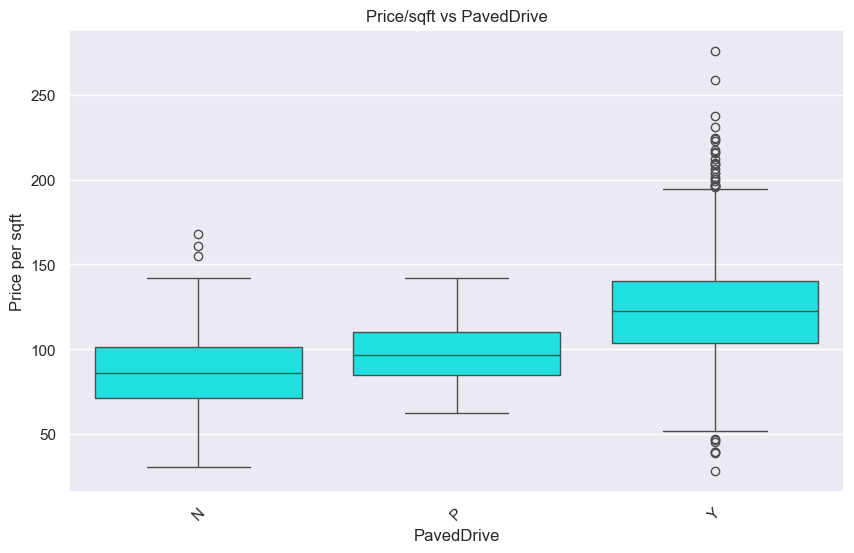

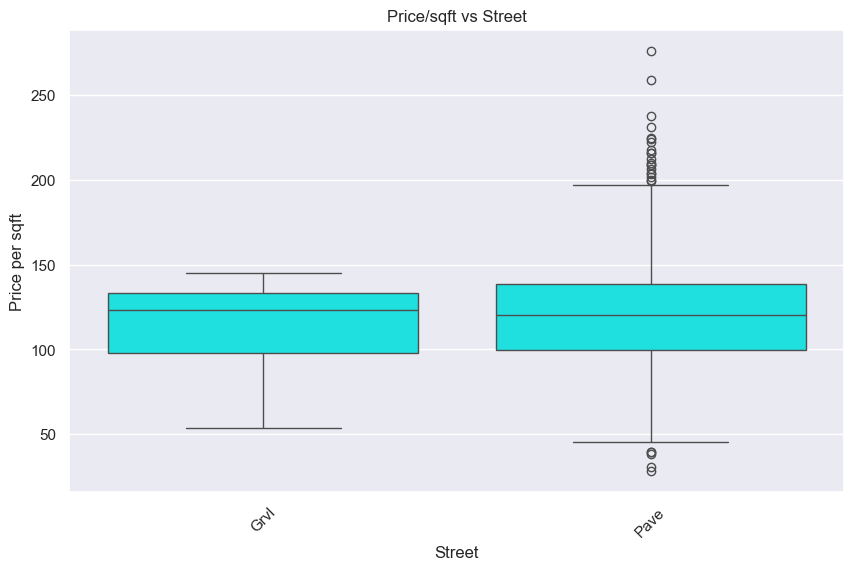

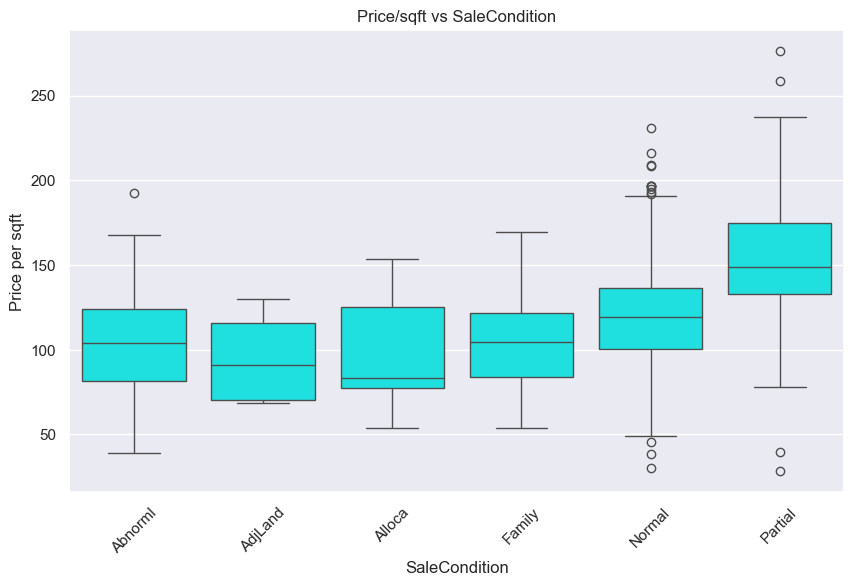

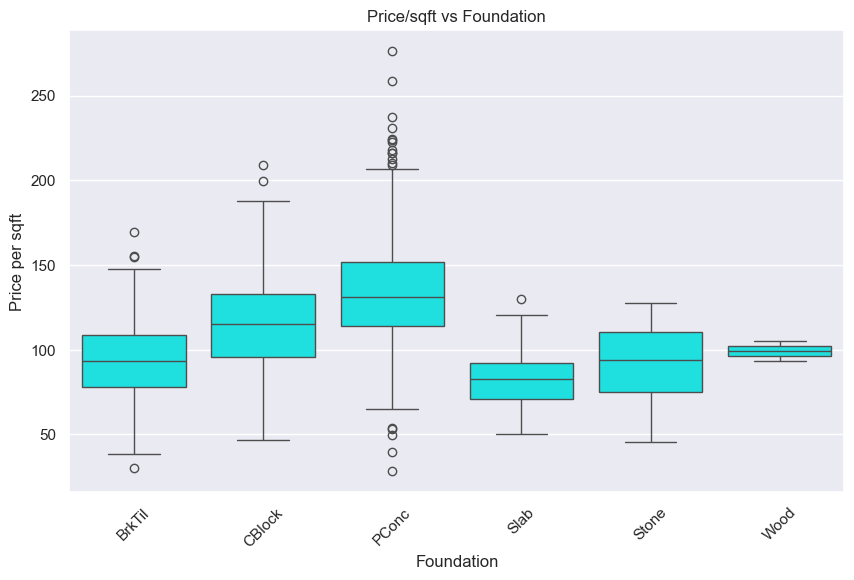

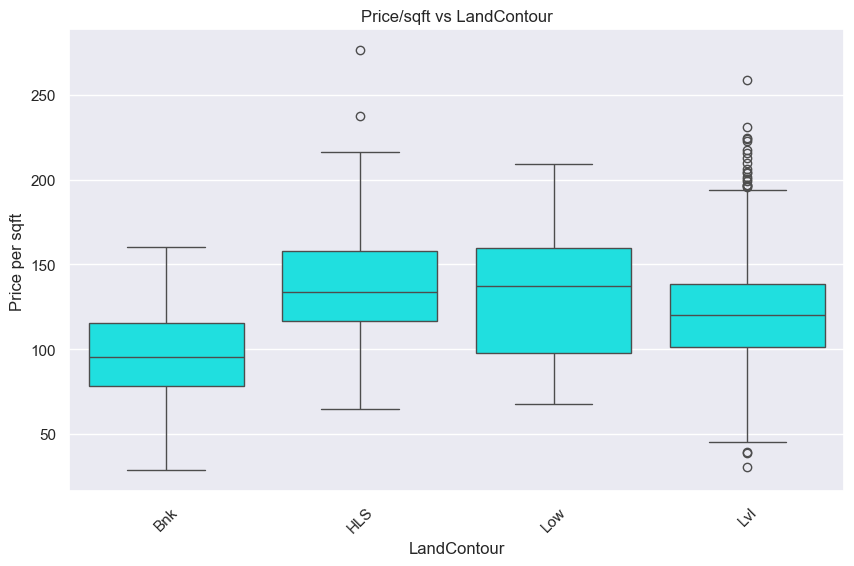

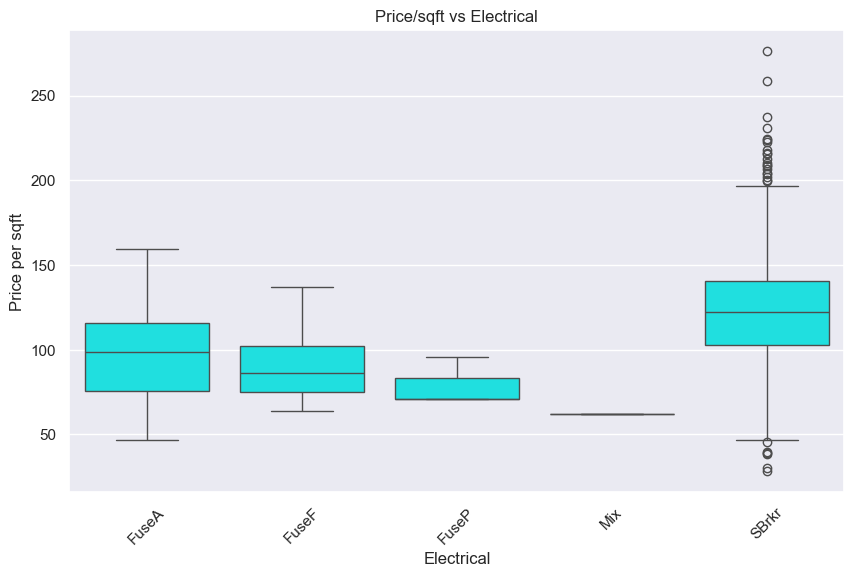

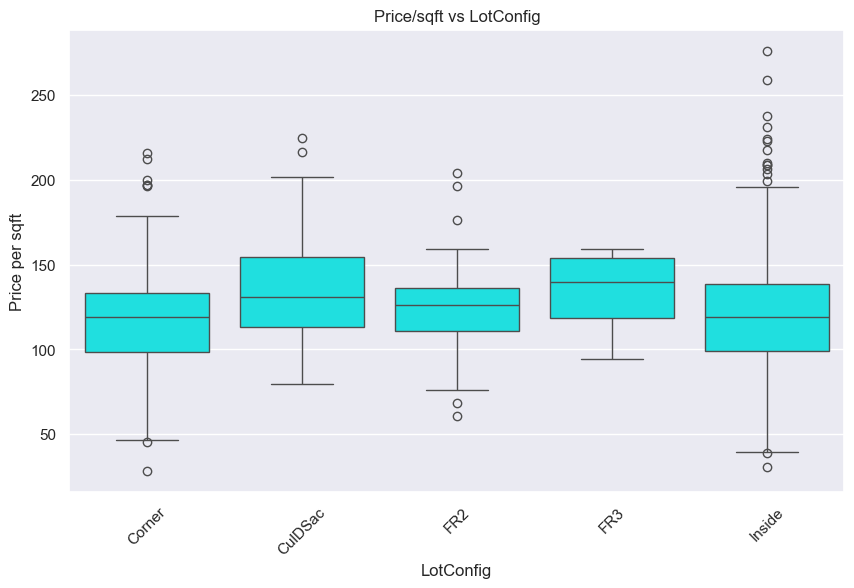

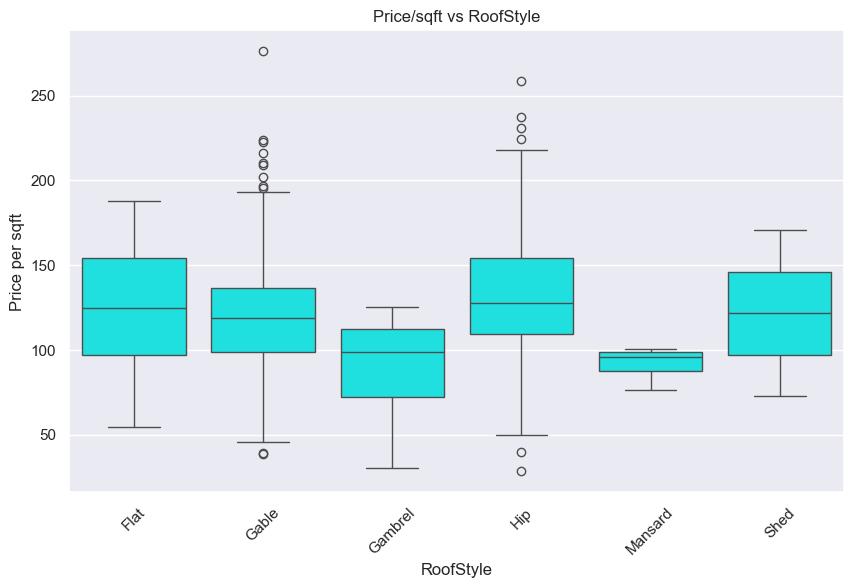

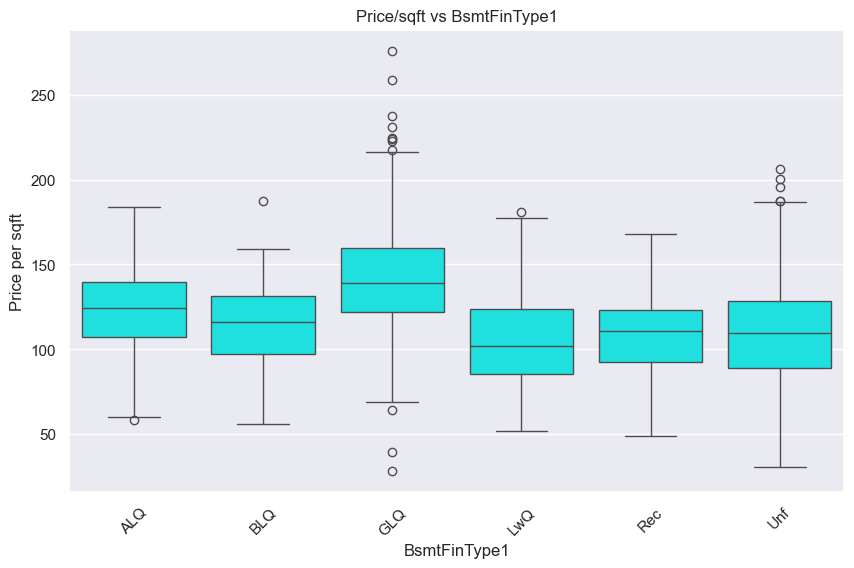

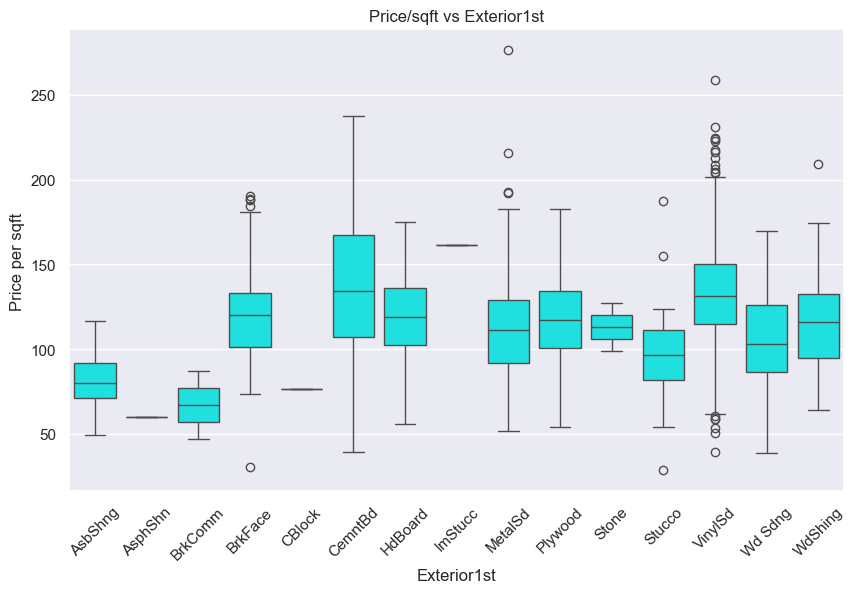

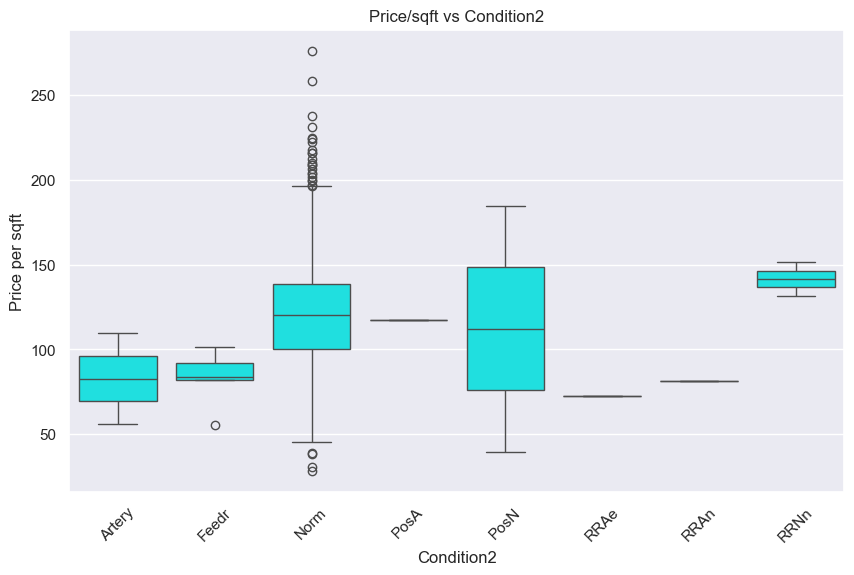

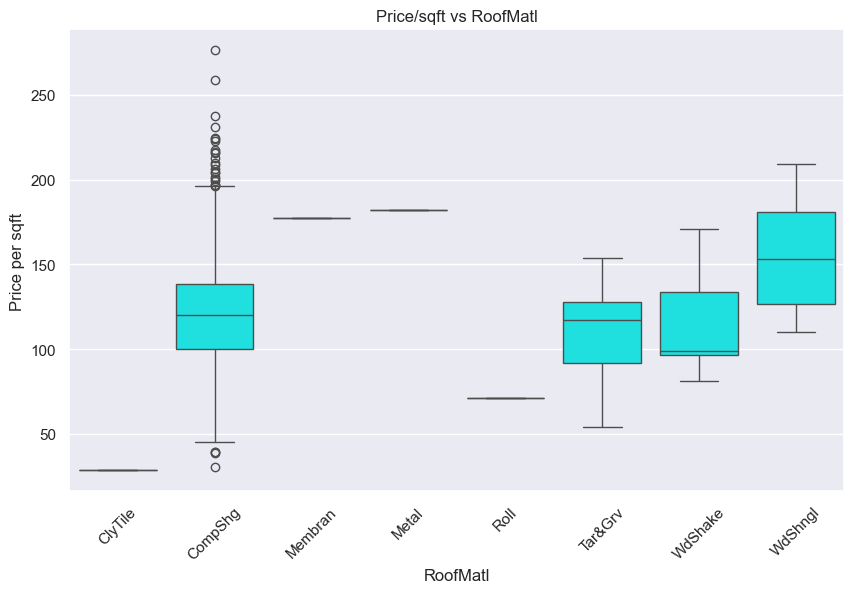

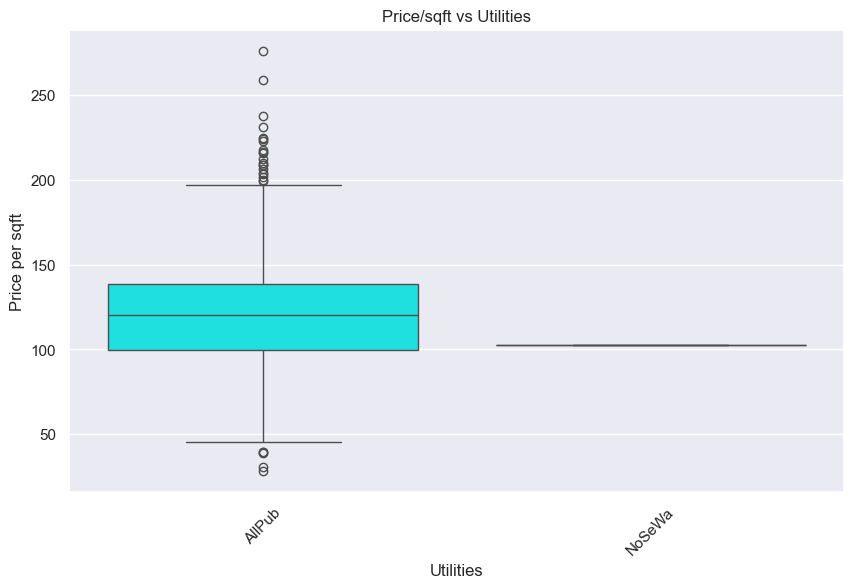

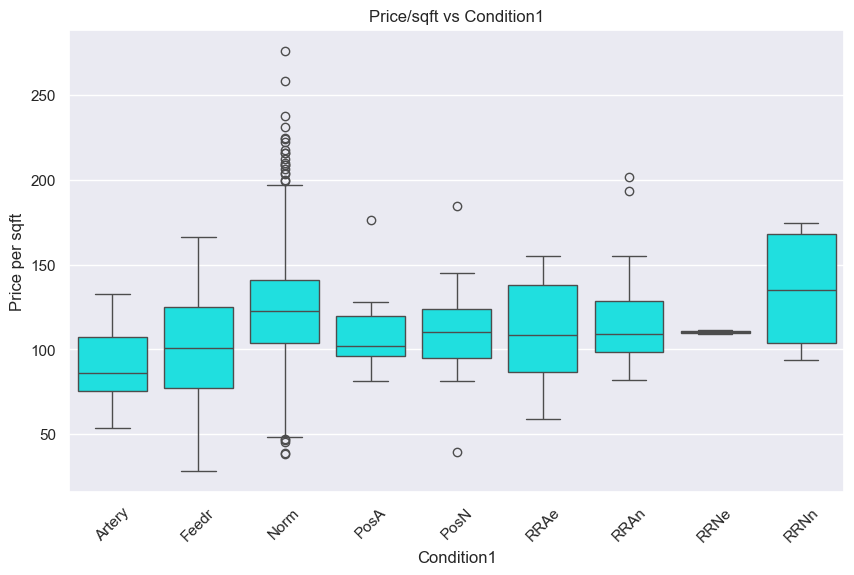

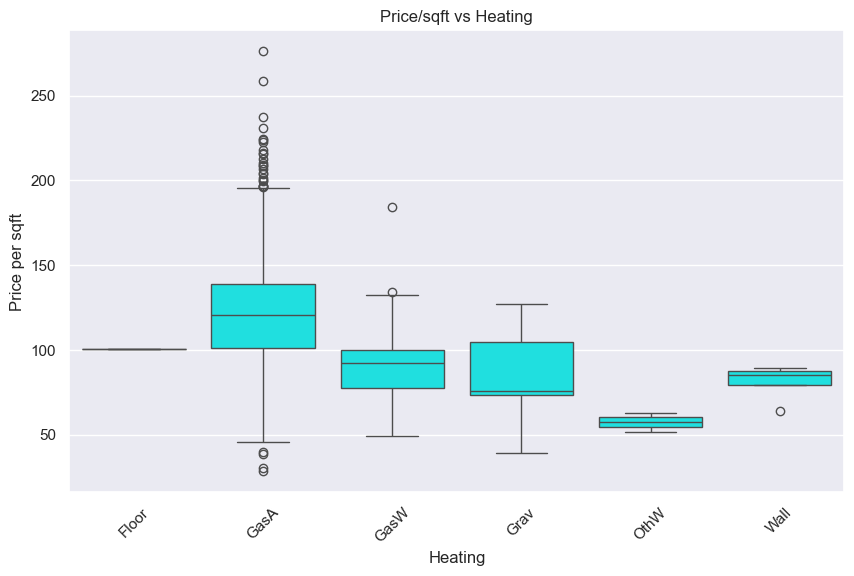

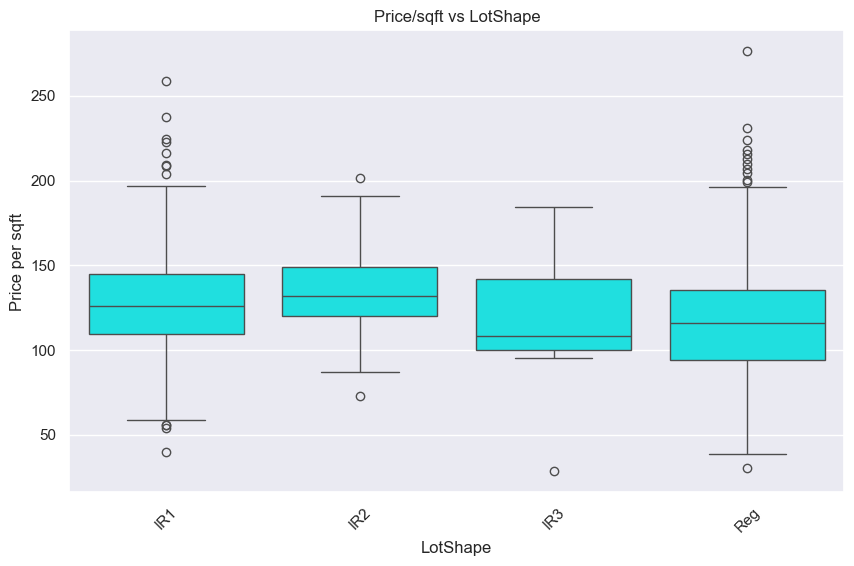

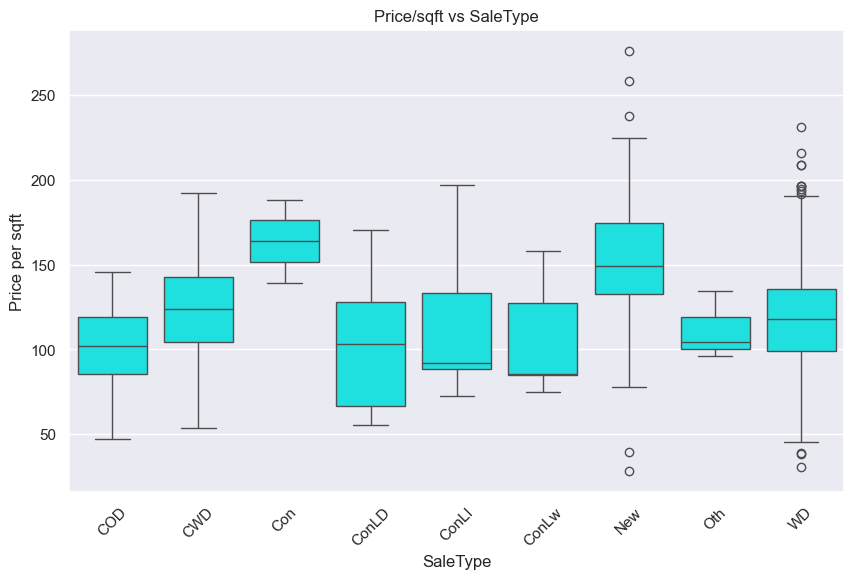

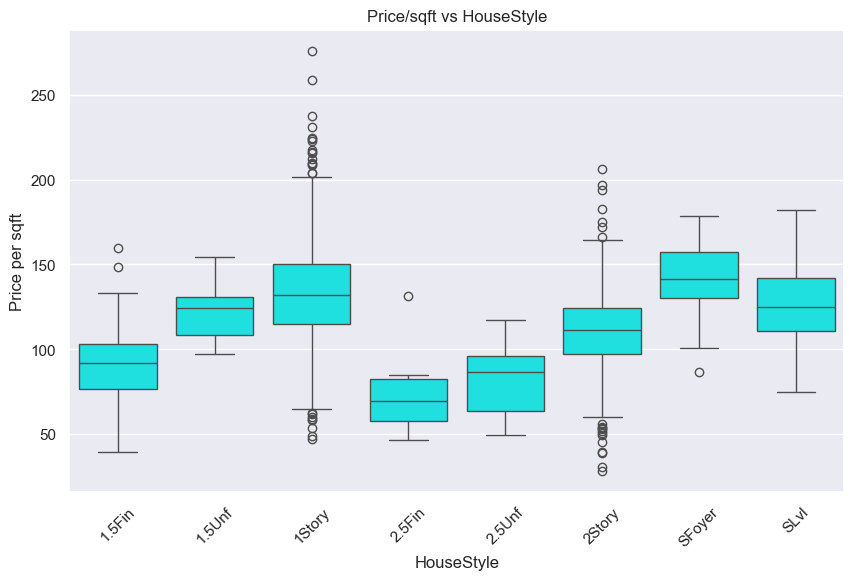

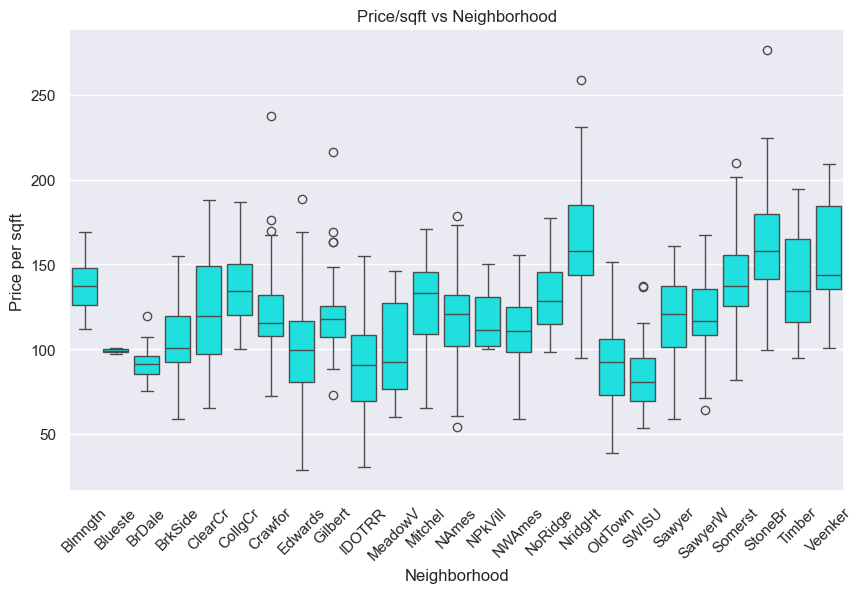

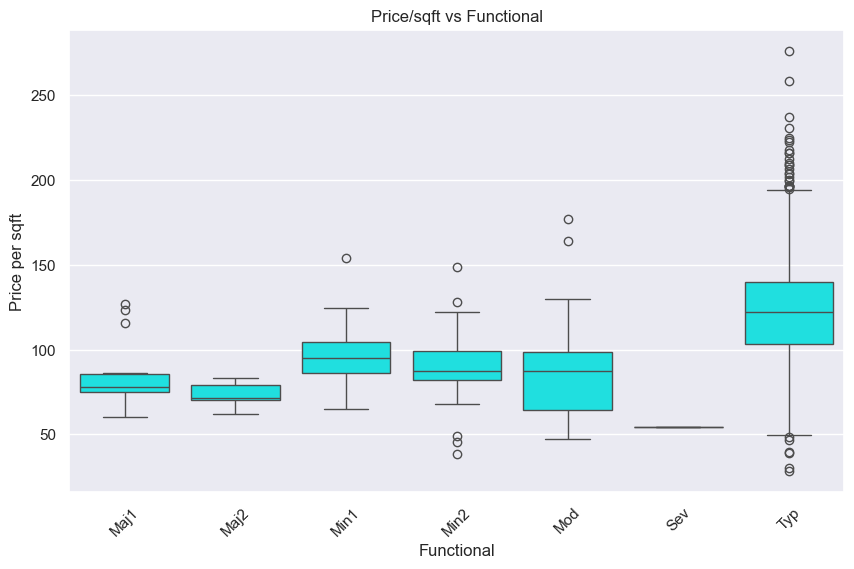

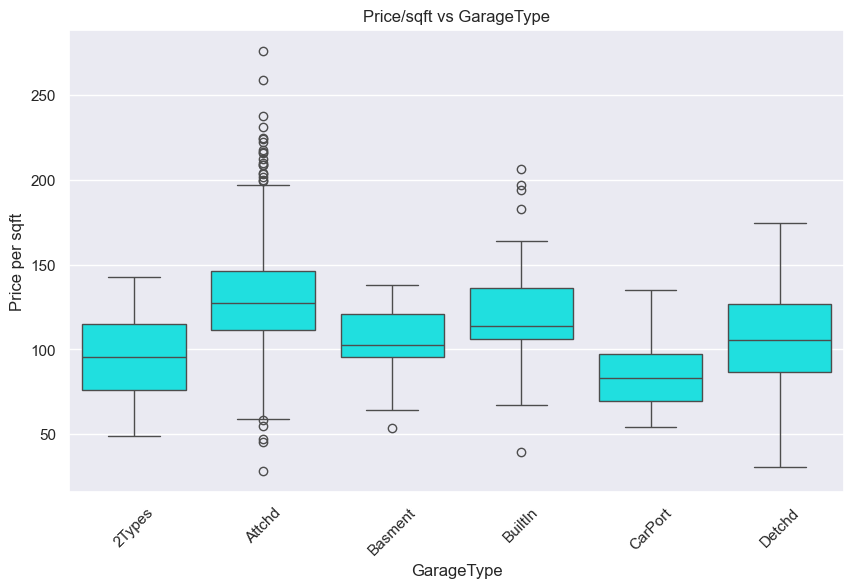

In [29]:
# plot the non-ordinal factors
for col in qualitatitve_non_Ord:    
    my_plot = sns.boxplot(data =data_train, x=col, y='price_per_sqft', color = 'cyan')
    plt.xticks(rotation=45)
    plt.ylabel("Price per sqft")
    plt.title("Price/sqft vs " + col)
    plt.show()

#### Quantitative Factors

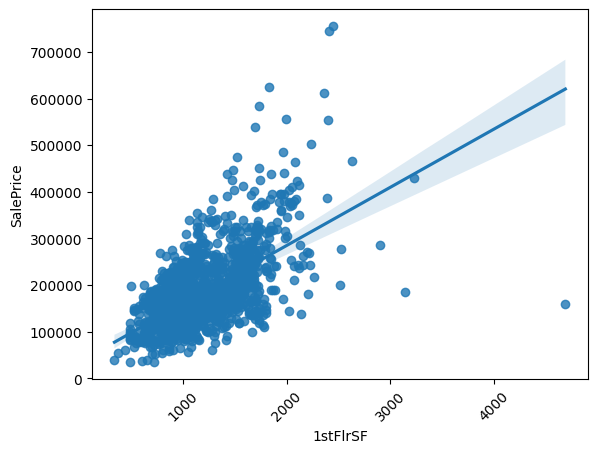

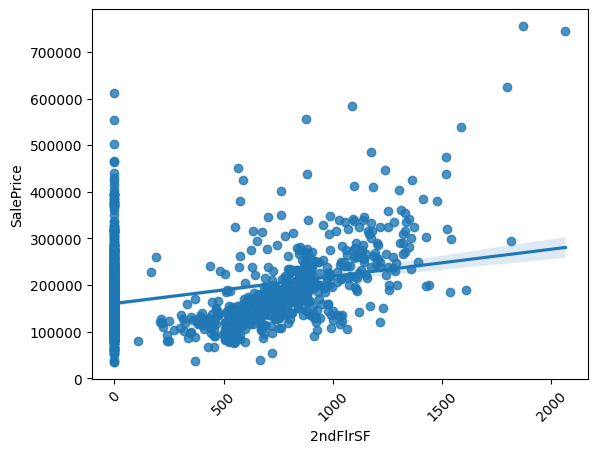

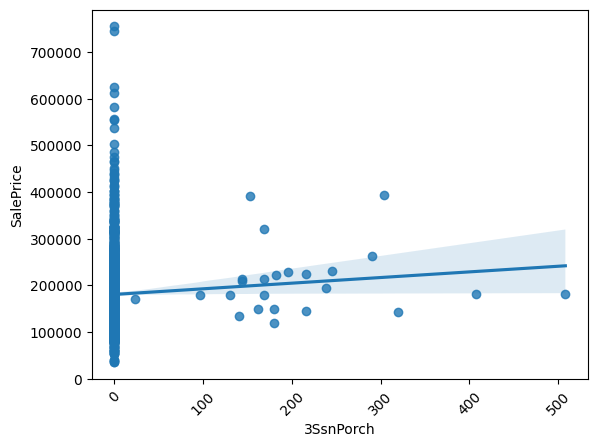

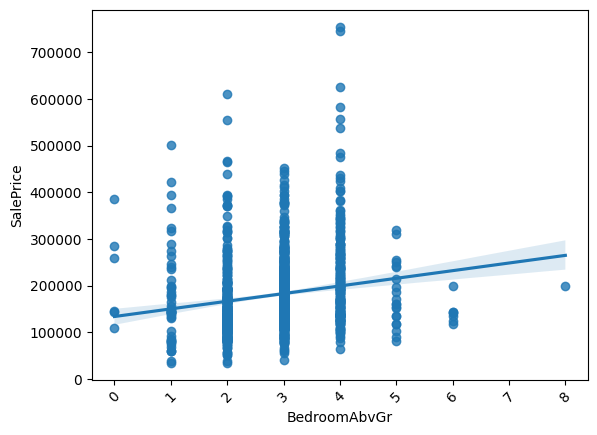

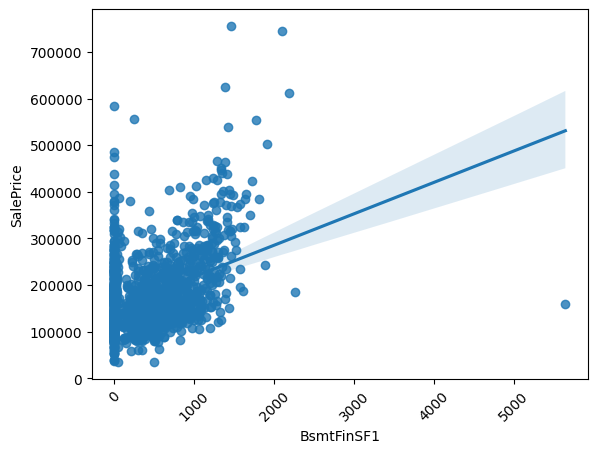

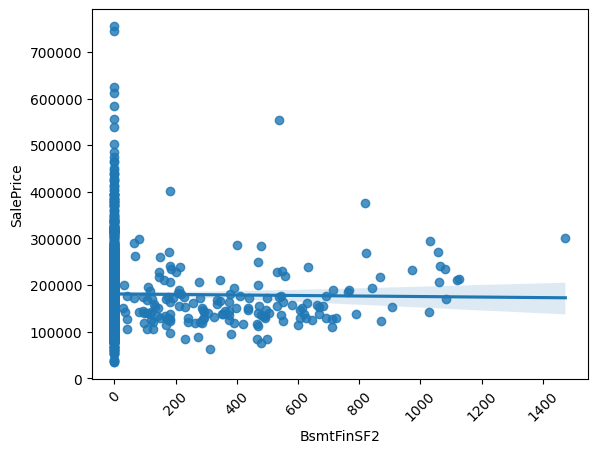

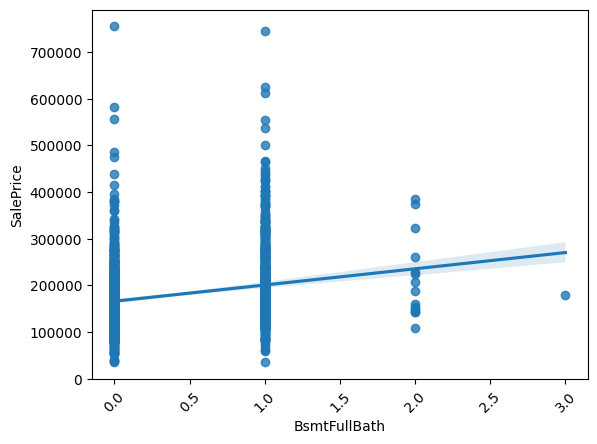

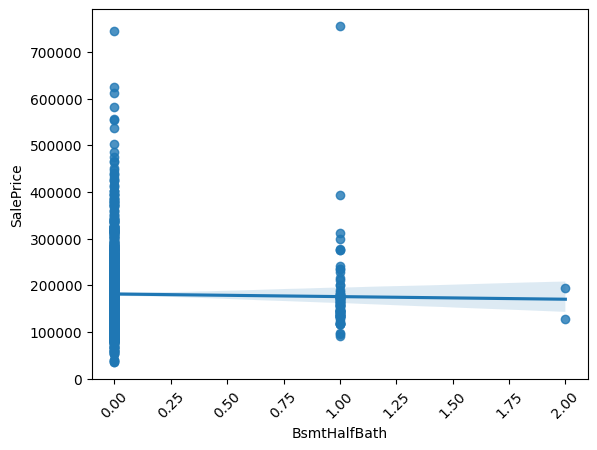

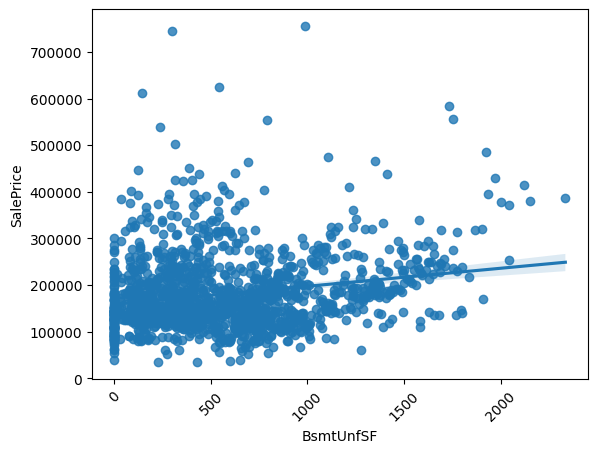

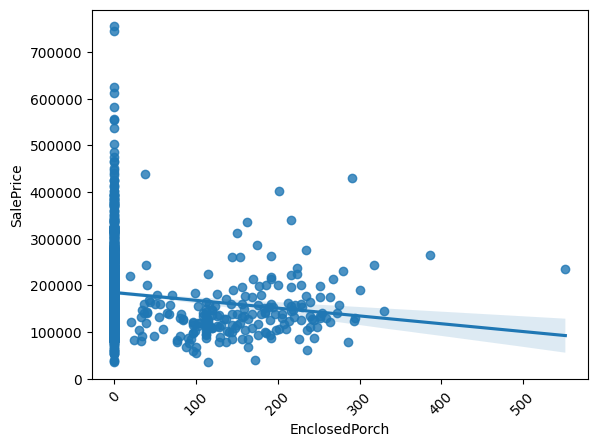

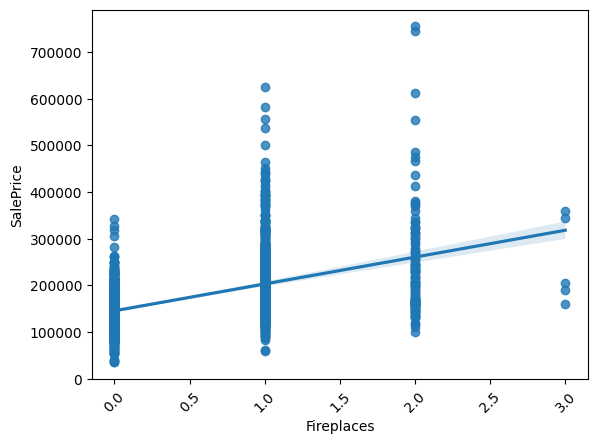

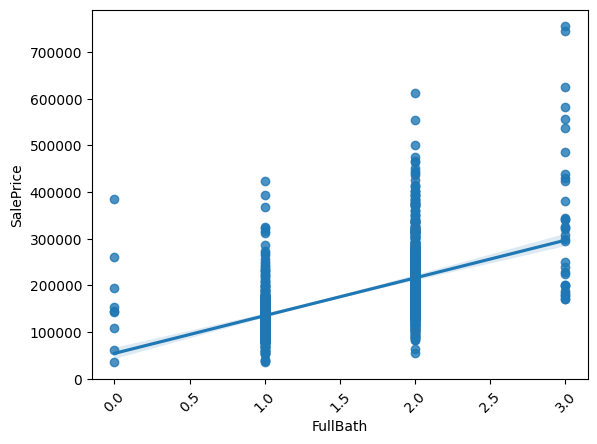

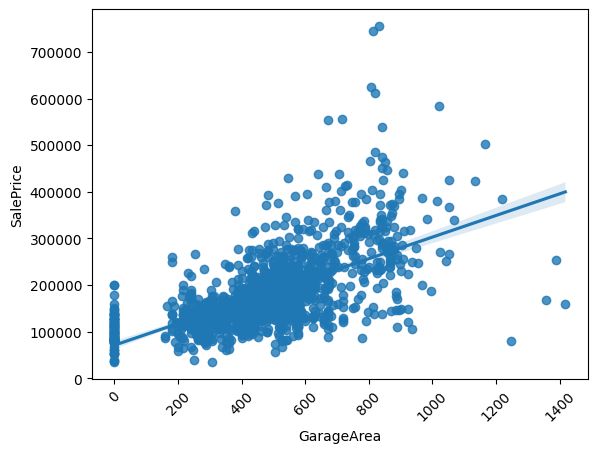

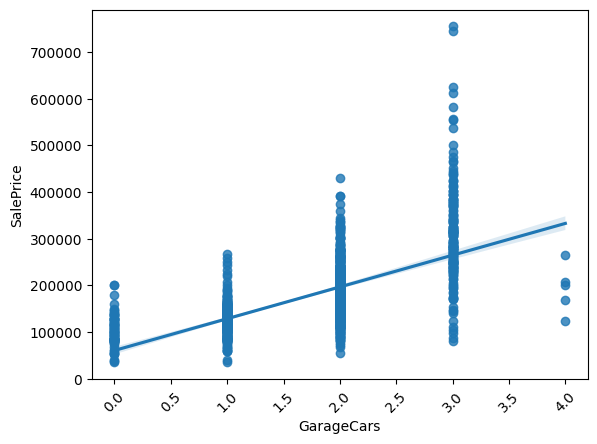

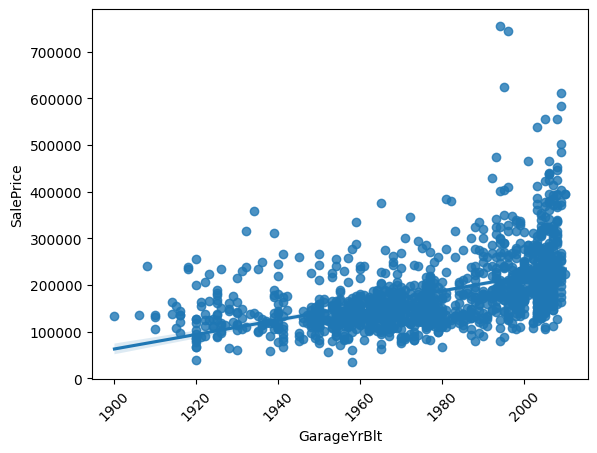

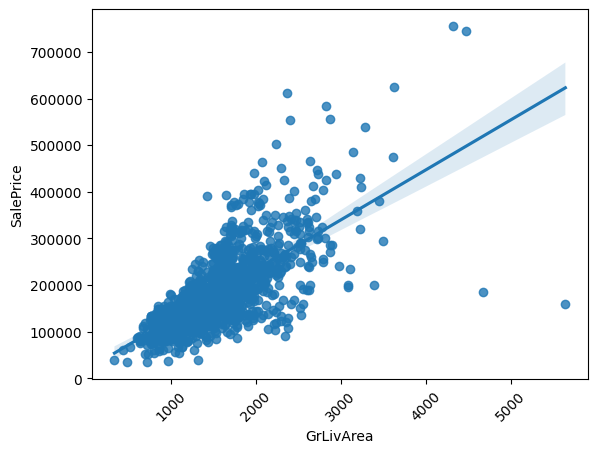

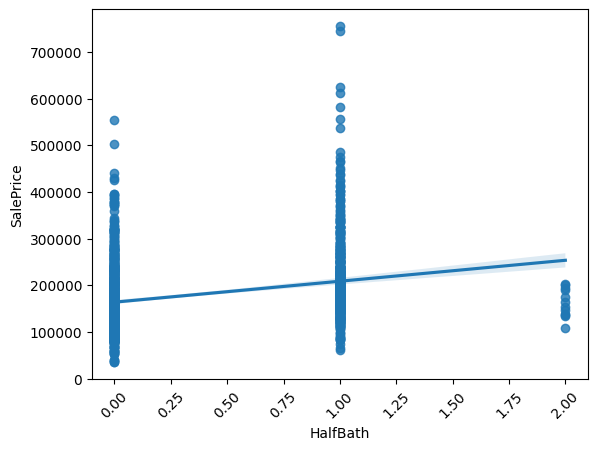

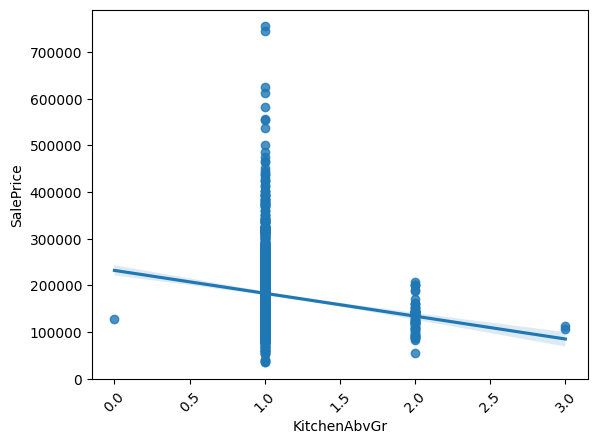

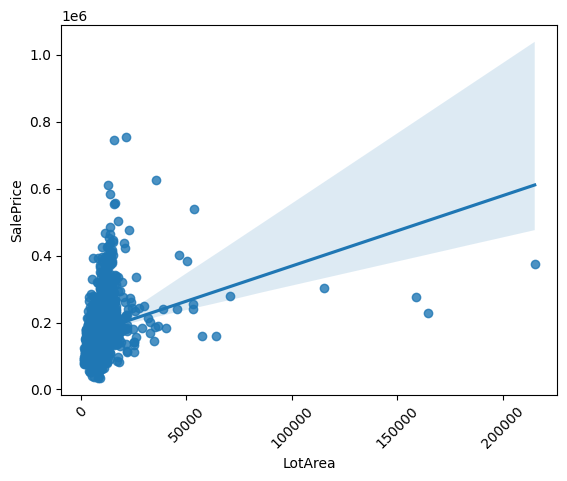

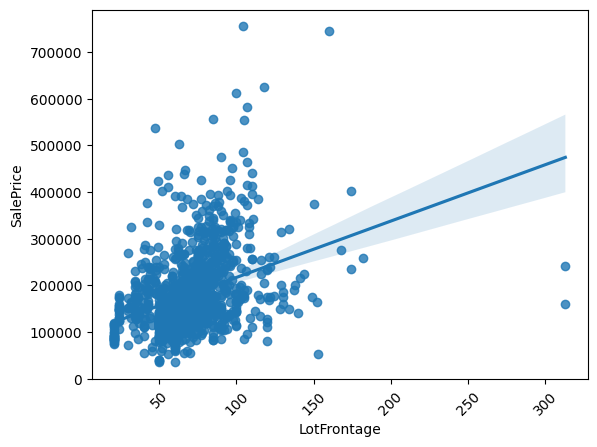

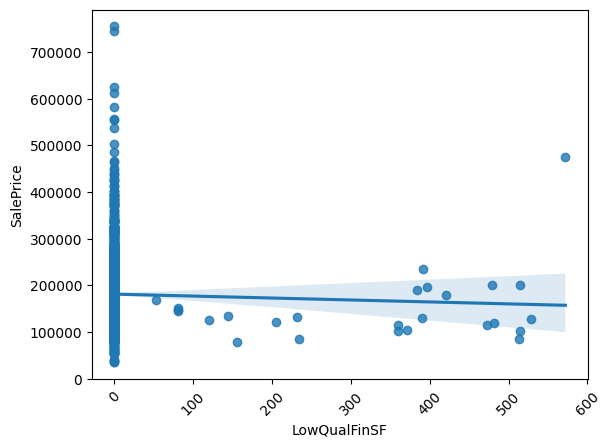

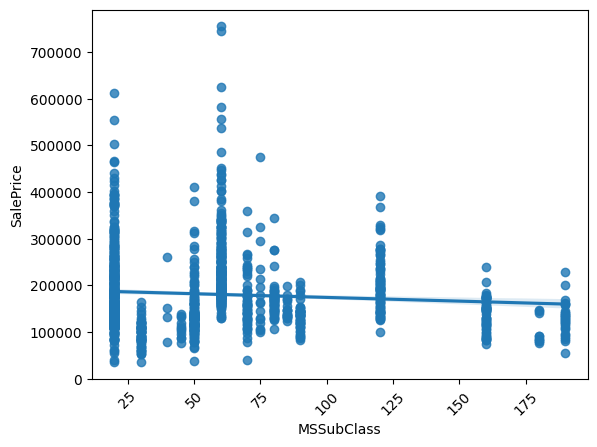

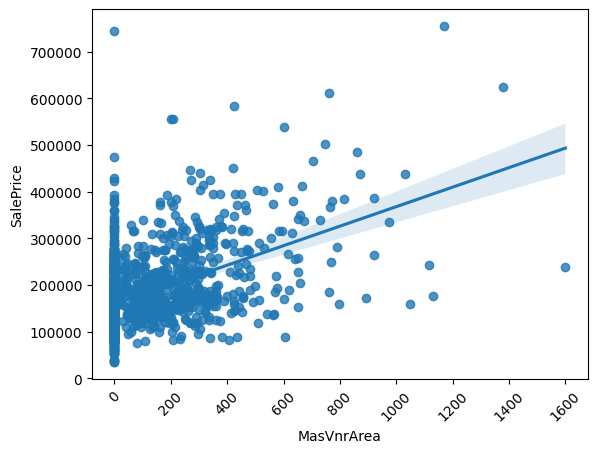

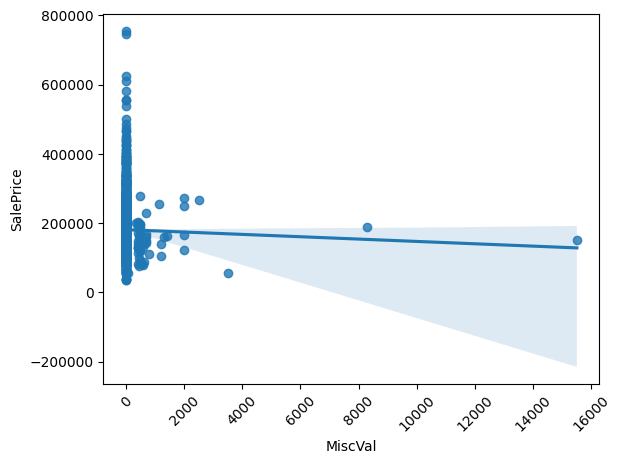

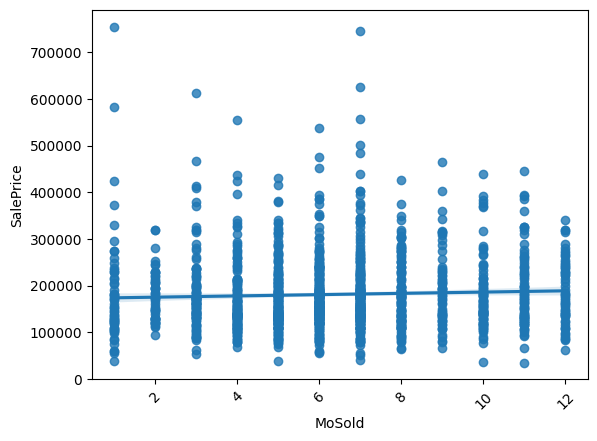

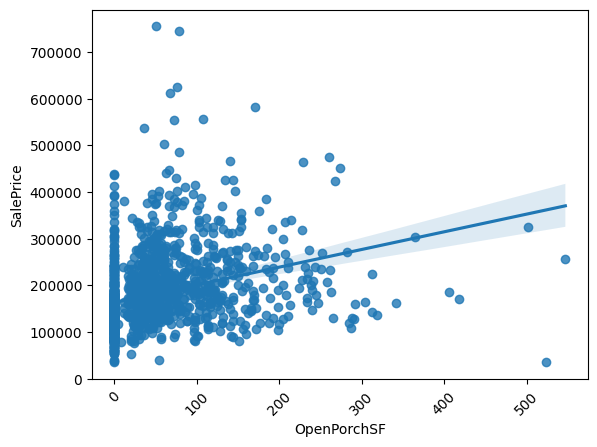

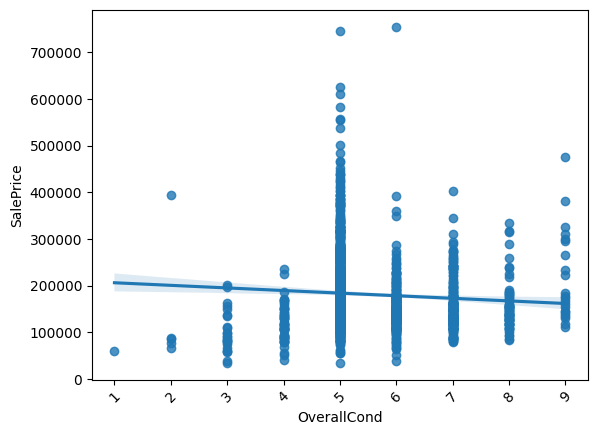

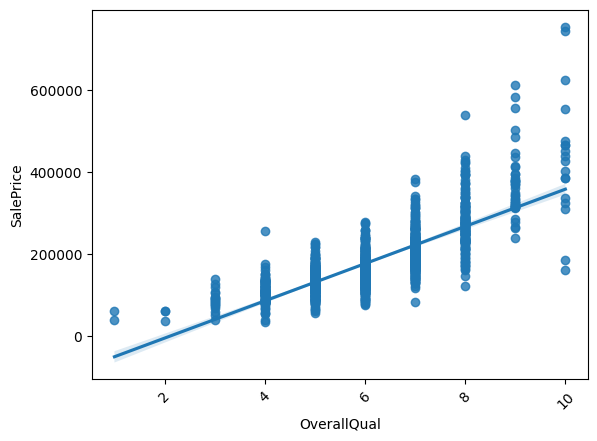

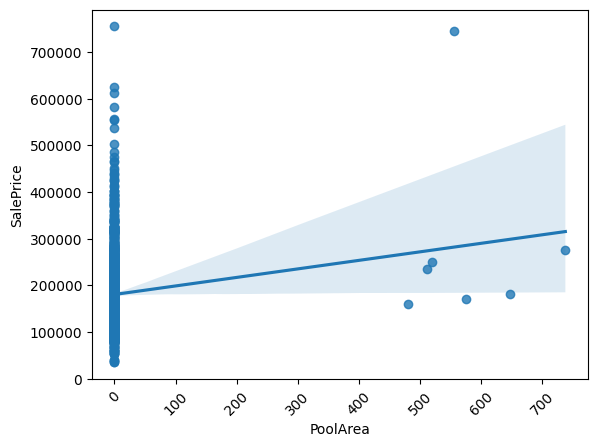

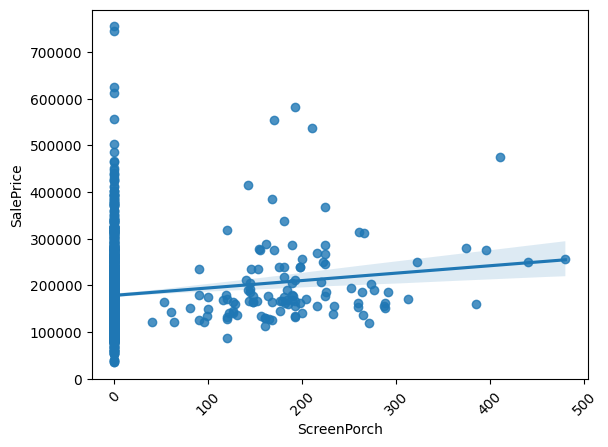

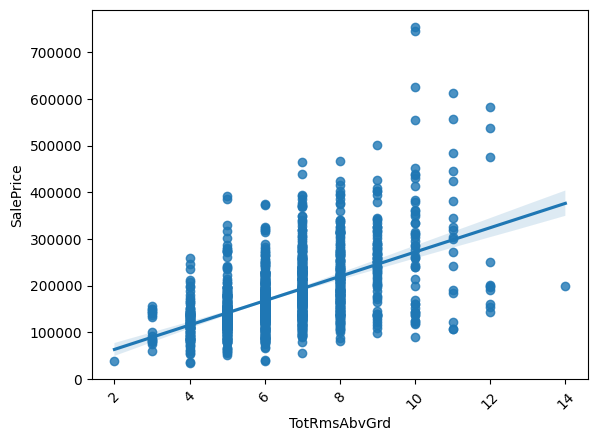

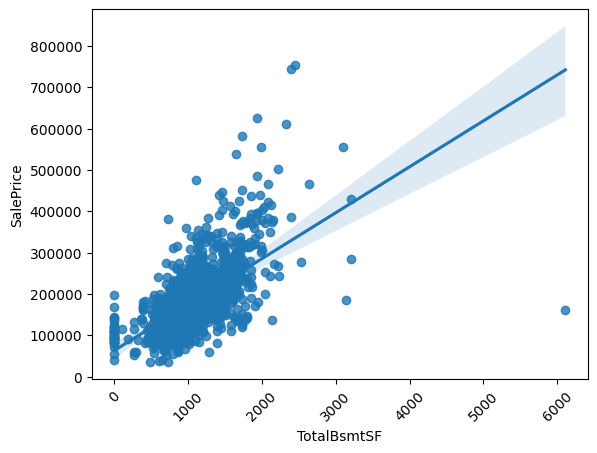

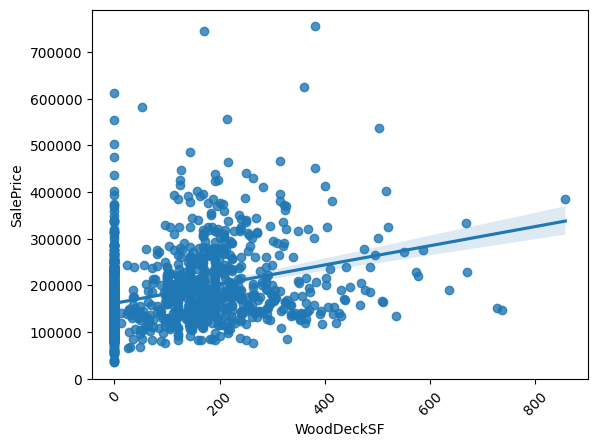

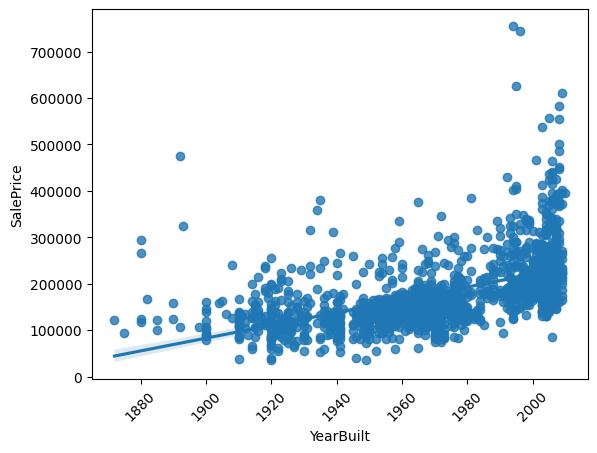

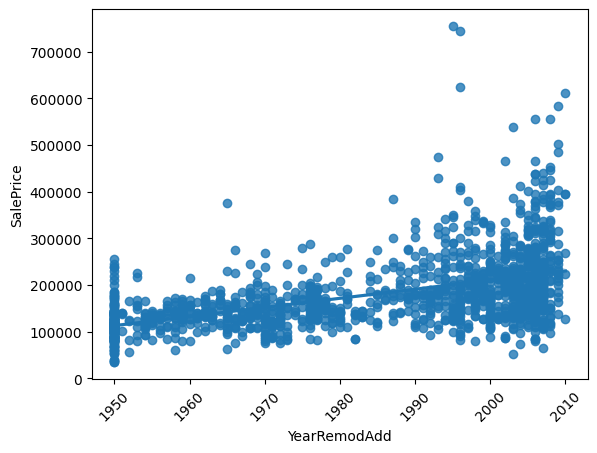

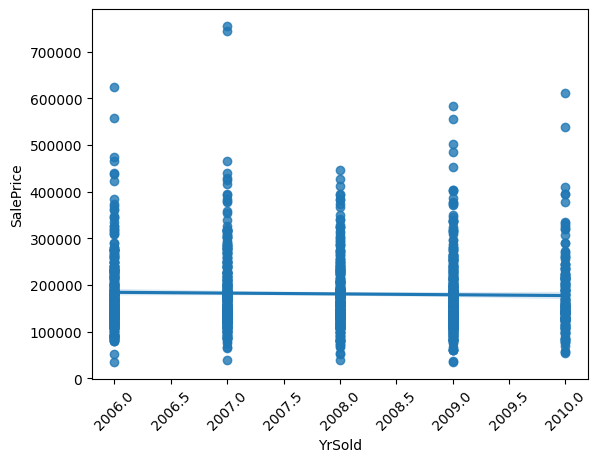

In [17]:
for col in quantitative:
    my_plot = sns.regplot(x=data_train[col], y=y)
    plt.xticks(rotation=45)
    plt.show()